In [1]:
import sys
print(sys.executable)

/Users/login/miniconda3/envs/skbio2/bin/python


The purpose of this file is to load the ASV table, load and compare clustered sequences, check each for structural artifacts with a PCA paired with a Chi-Squared test, make some diagnostic figures, remove low frequency features, compare UNIFRAC-type and conventional distances between samples, and then make a hierarchy visualize the similarities between samples, and save the final output matrix.

#### Step 1: Load packages and OTU abundance table

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('mode.chained_assignment', None)
import yaml

# load raw abundance data
abund_feather = '../otu_data/tree_data/hq_asv_table.feather'
abund_tsv = "../otu_data/tree_data/hq_asv_table.tsv"
if not os.path.exists(abund_feather):
    abund_df = pd.read_csv(abund_tsv, sep="\t")
    abund_df.to_feather(abund_feather)
else:
    abund_df = pd.read_feather(abund_feather, use_threads=True).set_index('Samples')
    
print("Read in abundance table with {} rows and {} columns".format(abund_df.shape[0], abund_df.shape[1]))
# load full sample sheet
config_file = "config.yml"
with open(config_file, 'r') as stream:
    cfg_dict = yaml.safe_load(stream)

data_dir = cfg_dict['data_directory']
sample_sheet_fn = cfg_dict['sample_sheet']
sample_sheet = pd.read_csv(sample_sheet_fn, sep="\t")
print("Read in metadata table with {} rows and {} columns".format(sample_sheet.shape[0], sample_sheet.shape[1]))

# Fix weird date
sample_sheet.loc[sample_sheet['DateMMDDYY'] == 'Mix9', 'DateMMDDYY'] = '100516'

# make weird samples (not mine or controls, some not in sample sheet) their own group 
weird_samples = set(abund_df.index) - set(sample_sheet.SampleID.unique())
abund_df_jm = abund_df.drop(weird_samples, axis=0)
print("After removing others' samples abundance table size is {}".format(abund_df_jm.shape))

Read in abundance table with 441 rows and 54467 columns
Read in metadata table with 413 rows and 77 columns
After removing others' samples abundance table size is (407, 54467)


#### Prep the sample sheet 

In [3]:
sample_sheet2 = sample_sheet.set_index('SampleID')
sub_sample_sheet = sample_sheet2.loc[abund_df_jm.index, :]
sub_sample_sheet.loc[sub_sample_sheet.DepthName.isnull(), 'DepthName'] = 'LAB'
sub_sample_sheet.loc[sub_sample_sheet.DepthName == 'Surface', 'DepthName'] = '1'
sub_sample_sheet.loc[sub_sample_sheet.DepthName == '0', 'DepthName'] = '1'
sub_sample_sheet.loc[[i for i in sub_sample_sheet.index if 'FiltCtrl' in i], 'StationName'] = 'CB44'
select_metadata = ['DateMMDDYY', 'StationName', 'DepthName', 'sequencing ID']

lat_lon_fn = "../otu_data/CB_Locations.tsv"
lat_lon = pd.read_csv(lat_lon_fn, sep="\t", index_col=0)
cb2lat, cb2lon = {'LAB': 00.0}, {'LAB': 00.0}

for stat_ in lat_lon.index:
    if stat_.replace(".", "") in sub_sample_sheet.StationName.unique():
        cb2lat[stat_.replace(".", "")] = round(lat_lon.loc[stat_, 'Latitude'], 3) 
        cb2lon[stat_.replace(".", "")] = round(lat_lon.loc[stat_, 'Longitude'], 3) 


sub_sample_sheet['Latitude'] = sub_sample_sheet.StationName.map(cb2lat)
sub_sample_sheet['Longitude'] = sub_sample_sheet.StationName.map(cb2lon)

read_counts = pd.read_csv("../otu_data/trim_stats/read_counts.tsv", sep="\t", header=None, index_col=0)
sub_reads = read_counts.loc[sub_sample_sheet.index, :]
sub_reads.columns = ['RawCount', 'TrimCount']

read_bins = [5e3, 1e4, 2.5e4, 5e4, 1e5, 2.5e5, 5e5, 1e6, 2.5e6]
read_discrete = pd.DataFrame(index=sub_reads.index, columns=['RawCount_b', 'TrimCount_b'],
                            data=np.zeros(sub_reads.shape))
for rb in read_bins:
    r_bool = sub_reads['RawCount'] >= rb
    read_discrete.loc[r_bool, 'RawCount_b'] += 1
    t_bool = sub_reads['TrimCount'] >= rb
    read_discrete.loc[t_bool, 'TrimCount_b'] += 1
    print("{} and {} libraries incremented".format(r_bool.sum(), t_bool.sum()))

meta_data_df = sub_sample_sheet.join(sub_reads).join(read_discrete)

md_df = meta_data_df.copy()
odu_set = set(md_df[md_df['Short sample name'].str.contains("ODU") | 
                    md_df["Sampling notes"].str.contains("ODU")].index)
dnr_set = set(md_df[md_df['Short sample name'].str.contains("DNR") | 
                    md_df["Sampling notes"].str.contains("DNR")].index)

dnr_set.update([i for i in md_df.index if 'FiltCtrl' in i])
print(len(odu_set), len(dnr_set), len(odu_set.intersection(dnr_set)))

non_pl = odu_set.union(dnr_set)
md_df_other = md_df.loc[~md_df.index.isin(non_pl), :]
possibly_pl = set(md_df_other[md_df_other.StationName == 'CB33C'].index)

print(len(possibly_pl), len(possibly_pl.intersection(odu_set)), len(possibly_pl.intersection(dnr_set)))

meta_data_df = meta_data_df.join(pd.Series(index=meta_data_df.index, name="CollectionAgency"))
meta_data_df.loc[odu_set, 'CollectionAgency'] = 'ODU'
meta_data_df.loc[dnr_set, 'CollectionAgency'] = 'DNR'
meta_data_df.loc[possibly_pl, 'CollectionAgency'] = 'Preheim'

print(meta_data_df.CollectionAgency.isnull().sum(), meta_data_df.CollectionAgency.shape)

sid_map = {'esakows1_132789': 'e_13',
           'controls': 'controls',
           'esakows1_152133_plate_1': 'e_15_1',
           'esakows1_152133_plate_2': 'e_15_2',
           'Keith_Maeve1_138650': 'KM',
           'Miseq_data_SarahPreheim_Sept2016': 'Miseq_sp',
           'sprehei1_123382': 'spr12',
           'sprehei1_149186': 'spr14'}

print(meta_data_df["sequencing ID"].unique())
meta_data_df.loc[:, 'sequencing_ID'] = meta_data_df.loc[:, 'sequencing ID'].map(sid_map)
select_metadata.remove("sequencing ID"); select_metadata.append("sequencing_ID");
print(meta_data_df.loc[:, "sequencing_ID"].unique())

control_libs = (['178A_WaterBathControlA', '178B_WaterBathControlB'])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("Blank")])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("Mix9")])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("CDSBBR")])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("EMPTY")])
control_libs += list(abund_df_jm.index[meta_data_df['Short sample name'].str.contains("_Neg")])
control_libs += list(abund_df_jm.index[meta_data_df['Short sample name'].str.contains("ML0")])
control_libs += list(abund_df_jm.index[meta_data_df['Short sample name'].str.contains("_Pos")])
control_libs = list(set(control_libs))

meta_data_df.loc[control_libs +[i for i in meta_data_df.index if 'Filt' in i], "sequencing_ID"] = 'controls'

394 and 387 libraries incremented
390 and 375 libraries incremented
375 and 341 libraries incremented
353 and 297 libraries incremented
310 and 185 libraries incremented
154 and 31 libraries incremented
43 and 6 libraries incremented
2 and 0 libraries incremented
0 and 0 libraries incremented
119 125 0
148 0 0
15 (407,)
['esakows1_132789' 'esakows1_152133_plate_1' 'esakows1_152133_plate_2'
 'Keith_Maeve1_138650' 'Miseq_data_SarahPreheim_Sept2016'
 'sprehei1_123382' 'sprehei1_149186']
['e_13' 'e_15_1' 'e_15_2' 'KM' 'Miseq_sp' 'spr12' 'spr14']


#### Here we will define a function that drops features present mostly in controls and samples with low yields

In [4]:
def decrease_sparsity(abund_table, ctrls, abund_thresh=0.002, rare_thresh=3000, addl_keys=[]):
    """Takes an abundance table and a list of control indexes
       Removes OTUs with 50% or more of their abundances in controls.
       Removes OTUS below user set abundances threshold.
       Removes features below rarefaction threshold.
       Removes additional features according to string matched key"""
    otus_to_strip = set()
    control_otus = abund_table.columns[abund_table.loc[ctrls, :].sum() > 0]
    total_in_controls = abund_table.loc[ctrls, control_otus].sum()
    total_in_non_controls = abund_table.loc[:, control_otus].sum()
    mostly_in_controls = control_otus[(total_in_controls / total_in_non_controls) > 0.5]
    otus_to_strip.update(mostly_in_controls)
    print("{} are to be removed as contaminants".format(len(otus_to_strip)))
    abund_ra = abund_table.div(abund_table.sum(1), axis=0)
    low_abund = abund_table.columns[(abund_ra > abund_thresh).sum() == 0]
    otus_to_strip.update(low_abund)
    print("{} are to be removed after adding low abundance OTUs".format(len(otus_to_strip)))
    presence_absence = ((abund_table > 0))
    infrequent_appearances = abund_table.columns[presence_absence.sum() < 2]
    otus_to_strip.update(infrequent_appearances)
    print("{} are to be removed after adding low freq OTUs".format(len(otus_to_strip)))
    div_samples = presence_absence.sum(1)
    div_thresh = div_samples["96_ZymoControl_R1"]
    print("Removing samples with fewer features than Zymo ({})".format(div_thresh))
    abund_to_return = abund_table.copy()
    for ak in addl_keys: 
        ctrls += list(abund_table.index[abund_table.index.str.contains(ak)])
    
    ctrls += list(abund_table.index[div_samples < div_thresh])
    ctrls += list(abund_table.index[abund_to_return.sum(1) < rare_thresh])
    
    fmt_libs = "".join(["\t"+cl+"\n" for cl in set(ctrls)])
    print("Removed libraries are:\n{}".format(fmt_libs))
        
    abund_to_return = abund_to_return.loc[~(abund_table.index.isin(ctrls)), 
                                          ~abund_table.columns.isin(otus_to_strip)]
    
    print("{}, {} are shapes after bad otus and low yeild samples".format(abund_table.shape, abund_to_return.shape))
    return abund_to_return

print("Decreasing sparsity of full table:")
abund_df_og_s1 = decrease_sparsity(abund_df_jm, control_libs, abund_thresh=0.002, addl_keys=['Zymo'])
#abund_df_og_p1 = decrease_sparsity(abund_df_jm, control_libs, abund_thresh=0.0005, addl_keys=['Zymo'])
#abund_df_og_ = decrease_sparsity(abund_df_jm, control_libs, abund_thresh=0.00001, addl_keys=['Zymo'])

Decreasing sparsity of full table:
1894 are to be removed as contaminants
52526 are to be removed after adding low abundance OTUs
52559 are to be removed after adding low freq OTUs
Removing samples with fewer features than Zymo (12)
Removed libraries are:
	SB061815TAWCSCB33CDSBBR1TR1I2
	SB062716TAWCSLABDPCBR1TR1I602
	SB072215TAWCSCB33CD1BR1TR1I28
	SB092116TAWCSLABDNCBR1TR1I247
	178B_WaterBathControlB
	SB091817TAWCSCB73D12BR1TR1I512
	SB092616TAWCSLABDNABR1TR1I268
	92_Mix93_Control_R1
	SB072215TAWCSCB33CD5BR1TR1I32
	SB081216TAWCSCB61D11BR2TR1I193
	SB061815TAWCSCB33CD12BR1TR1I16
	SB062917TAWCSLABDPCBR1TR2I606
	SB062917TAWCSLABDPCBR1TR1I607
	SB082015TAWCSCB33CD6BR1TR1I57
	SB061815TAWCSCB33CD10BR2TR1I14
	SB061815TAWCSCB33CD16BR1TR1I20
	SB062917TAWCSLABDPCBR1TR3I608
	SB082916TAWCSCB71D20BR1TR1I239
	SBMix9TAWCSLABDPCBR1TR2I270
	SB072516TAWCSCB33CDSBBR1TR1I125
	93_PBS_Blank_Control
	SB062917TAWCSLABDPCBR1TR4I609
	SB062716TAWCSLABDNCBR1TR1I601
	SB082015TAWCSCB33CDSBBR1TR1I50
	96_ZymoControl_R1


#### More metadata prep work 

In [5]:
super_df = pd.concat([abund_df_og_s1, meta_data_df.loc[abund_df_og_s1.index, :]], axis=1)
super_df.DepthName = super_df.DepthName.apply(lambda x: "0"+x if len(x) == 1 else x)
super_df['Month'] = super_df.DateMMDDYY.apply(lambda x: x[:2])
super_df['Year'] = super_df.DateMMDDYY.apply(lambda x: x[-2:])
super_df['Month_Year'] = super_df.loc[:, ['Month', 'Year']].apply(lambda x: " ".join(x), axis=1)
sort_vars = ['Year', 'Month', 'Latitude', 'DepthName']
super_df.sort_values(sort_vars, ascending=[True, True, False, True], inplace=True)
super_df['Salinity_Group'] = pd.Series([""]*super_df.index.shape[0], index=super_df.index)
some_indexes = super_df.index[[0,1,2,100,101,102,200,201,202,-3,-2,-1]]
some_columns = ['DepthName', 'Month', 'Year', 'Month_Year', 'CollectionAgency', 'Salinity_Group', 'sequencing_ID']
super_df.loc[some_indexes, some_columns]

DepthName Month Year Month_Year  \
Samples                                                          
SB061815TAWCSCB33CD0BR1TR1I3          01    06   15      06 15   
SB061815TAWCSCB33CD1BR1TR1I4          01    06   15      06 15   
SB061815TAWCSCB33CD2BR1TR1I5          02    06   15      06 15   
SB071116TAWCSCB54D25BR1TR1I157        25    07   16      07 16   
SB071116TAWCSCB54D25BR2TR1I158        25    07   16      07 16   
SB071116TAWCSCB71D20BR1TR1I167        20    07   16      07 16   
SB050817TAWCSCB44D31BR1TR1I329        31    05   17      05 17   
SB050817TAWCSCB51D33BR1TR1I330        33    05   17      05 17   
SB050817TAWCSCB53D5BR1TR1I318         01    05   17      05 17   
SB091817TAWCSCB63D10BR1TR1I518        10    09   17      09 17   
SB091817TAWCSCB72D20BR1TR1I521        20    09   17      09 17   
SB091817TAWCSCB73D12BR1TR1I522        12    09   17      09 17   

                               CollectionAgency Salinity_Group sequencing_ID  
Samples                                                                       
SB061815TAWCSCB33CD0BR1TR1I3            Preheim                        spr12  
SB061815TAWCSCB33CD1BR1TR1I4            Preheim                        spr12  
SB061815TAWCSCB33CD2BR1TR1I5            Preheim                        spr12  
SB071116TAWCSCB54D25BR1TR1I157              ODU                           KM  
SB071116TAWCSCB54D25BR2TR1I158              ODU                           KM  
SB071116TAWCSCB71D20BR1TR1I167              ODU                        spr14  
SB050817TAWCSCB44D31BR1TR1I329              DNR                       e_15_1  
SB050817TAWCSCB51D33BR1TR1I330              DNR                       e_15_1  
SB050817TAWCSCB53D5BR1TR1I318               DNR                       e_15_1  
SB091817TAWCSCB63D10BR1TR1I518              ODU                       e_15_2  
SB091817TAWCSCB72D20BR1TR1I521              ODU                       e_15_2  
SB091817TAWCSCB73D12BR1TR1I522              ODU                        spr14

#### Import taxa table

In [7]:
taxa_file = "taxa_table.tsv"
data_path = "../otu_data/dada2_outputs"
tax_f = os.path.join(data_path, taxa_file)
taxa_df = pd.read_csv(tax_f, sep="\t")
OTU_Seqs = {taxa_df.loc[idx, taxa_df.columns[0]]:idx for idx in taxa_df.index}
OTU_Names = {idx:"OTU{}".format(idx+1) for idx in taxa_df.index }
OTU_name2seq = {OTU_Names[num]:seq for seq, num in OTU_Seqs.items()}
taxa_df.loc[:, taxa_df.columns[0]] = taxa_df.loc[:, taxa_df.columns[0]].apply(lambda x: OTU_Names[OTU_Seqs[x]])
taxa_df = taxa_df.set_index(taxa_df.columns[0])
taxa_df.loc[['OTU2880', 'OTU14561', 'OTU38271', "OTU54666", 'OTU15257', 'OTU30263', 'OTU2'], :]

Kingdom           Phylum                Class  \
Unnamed: 0                                                   
OTU2880      Archaea              NaN                  NaN   
OTU14561     Archaea              NaN                  NaN   
OTU38271     Archaea              NaN                  NaN   
OTU54666     Archaea  Nanoarchaeaeota        Woesearchaeia   
OTU15257    Bacteria   Proteobacteria  Gammaproteobacteria   
OTU30263    Bacteria   Proteobacteria  Gammaproteobacteria   
OTU2        Bacteria   Proteobacteria  Gammaproteobacteria   

                            Order                  Family Genus Species  
Unnamed: 0                                                               
OTU2880                       NaN                     NaN   NaN     NaN  
OTU14561                      NaN                     NaN   NaN     NaN  
OTU38271                      NaN                     NaN   NaN     NaN  
OTU54666                      NaN                     NaN   NaN     NaN  
OTU15257    Ectothiorhodospirales  Ectothiorhodospiraceae   NaN     NaN  
OTU30263    Ectothiorhodospirales  Ectothiorhodospiraceae   NaN     NaN  
OTU2        Ectothiorhodospirales  Ectothiorhodospiraceae   NaN     NaN

In [9]:
out_path = "../otu_data/tree_data"
fnames = ['query_high_abund002.fasta', 'query_high_abund0005.fasta']
abund_df_ogs = [abund_df_og_s1 ]#, abund_df_og_p1]
for fname, abund_df_og in zip(fnames, abund_df_ogs):
    heads = sorted(list(abund_df_og.columns))
    tails = [OTU_name2seq[i] for i in heads]
    with open(os.path.join(out_path, fname), "w") as wofh:
        print(wofh.write("".join([">{}\n{}\n".format(i, j) for i, j in zip(heads, tails)])))


495255


#### Lets make PCA plots colored by metadata columns

In [11]:
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr

rename_cols = {i - 1: 'PC' + str(i) for i in range(1, 3)}

abundance_tables = {'Strict':abund_df_og_s1.copy() }#,
#                    'Permissive': abund_df_og_p1.copy(),
#                    'Very Permissive': abund_df_og_.copy()}

sample_loadings = {}
for title_i, abund_i in abundance_tables.items():
    print("Transforming {} abundance table".format(title_i))
    rclr_i = rclr().fit_transform(abund_i.values)
    print("Decomposing {} abundance table".format(title_i))
    opt_i = OptSpace(rank=2).fit(rclr_i)
    sl_i = pd.DataFrame(opt_i.sample_weights, index=abund_i.index)
    sl_i = sl_i.rename(columns=rename_cols)
    sample_loadings[title_i] = sl_i


all_sls = pd.concat((sample_loadings[i] for i in sorted(sample_loadings.keys())), axis=1)
new_cols = [i+"_"+j for i in sorted(sample_loadings.keys()) for j in sample_loadings[i].columns]
all_sls.columns = new_cols
all_sls.corr()

Transforming Strict abundance table
Decomposing Strict abundance table


Strict_PC1  Strict_PC2
Strict_PC1    1.000000   -0.256053
Strict_PC2   -0.256053    1.000000

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
plt.style.use('seaborn-talk')

meta_data_df2 = meta_data_df.loc[abund_df_og_s1.index, :]
select_mdata = select_metadata + ['Latitude', 'Longitude', 'RawCount_b', 'TrimCount_b']

metas_ls = {'encoded':{}, 'raw':{}, 'encoding':{}, 'rev_coding':{}}
for sm in select_mdata:
    nct = meta_data_df2[sm].isnull().sum()
    metas_ls['raw'][sm] = meta_data_df2[sm].tolist()
    metas_ls['encoding'][sm] = {raw:code for code, raw in enumerate(sorted(set(metas_ls['raw'][sm])))}
    metas_ls['encoded'][sm] = [metas_ls['encoding'][sm][r] for r in metas_ls['raw'][sm]]
    metas_ls['rev_coding'][sm] = {code:raw for raw, code in metas_ls['encoding'][sm].items()}
    uct = len(metas_ls['encoding'][sm])

for title_i in sample_loadings.keys():
    plt.clf()
    fig, ax_i = plt.subplots(nrows=1, ncols=1, figsize=(12,12), dpi=250)
    ax_i.set_title("{}, colored by sequencing run".format(title_i))
    ticks_, labels_ = zip(*metas_ls['rev_coding']['sequencing_ID'].items())
    cmap_i = plt.cm.get_cmap('Spectral', len(labels_))
    im = ax_i.scatter(sample_loadings[title_i].iloc[:, 0], 
                      sample_loadings[title_i].iloc[:, 1], 
                      c=metas_ls['encoded']['sequencing_ID'], 
                      edgecolor='k', alpha=0.8, cmap=cmap_i)
    cbar = fig.colorbar(im, ticks=ticks_)
    cbar.ax.set_yticklabels(labels_)     
    ax_i.set_xlabel(sample_loadings[title_i].columns[0])
    ax_i.set_ylabel(sample_loadings[title_i].columns[1])
    ax_i.set_facecolor('0.6')
    ax_i.set_axisbelow(True)
    ax_i.minorticks_on()
    ax_i.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax_i.grid(which='minor', linestyle='-', linewidth='0.25', color='black')
#    texts = []
#    from adjustText import adjust_text
#    for ctrl_ in control_libs:
#        x = sample_loadings[title_i].loc[ctrl_, 'PC1']
#        y = sample_loadings[title_i].loc[ctrl_, 'PC2']
#        s = meta_data_df2.loc[ctrl_, 'Short sample name'] + "_" + sid_map[meta_data_df2.loc[ctrl_, 'sequencing ID']]
#        texts.append(plt.text(x, y, s))       
#    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    fig.subplots_adjust(right=0.8)
    figname = "PCA_{}_abthresh_seq_run_colors.png".format(title_i)
    figpath = os.path.join("../otu_data/pca_plots", figname)
    print("Saving {}".format(figname))
    plt.savefig(figpath)
    plt.clf()
    plt.close()
    

Saving PCA_Strict_abthresh_seq_run_colors.png


<Figure size 748.8x514.8 with 0 Axes>

Strict
Big samples: 18, Small: 23
0.6692523633556795 BvB
0.7863756613756614 SvS
0.9804683011615223 BvS
0.6907697434188604 BvB
0.785071642785738 SvS
0.7555814728423859 BvS


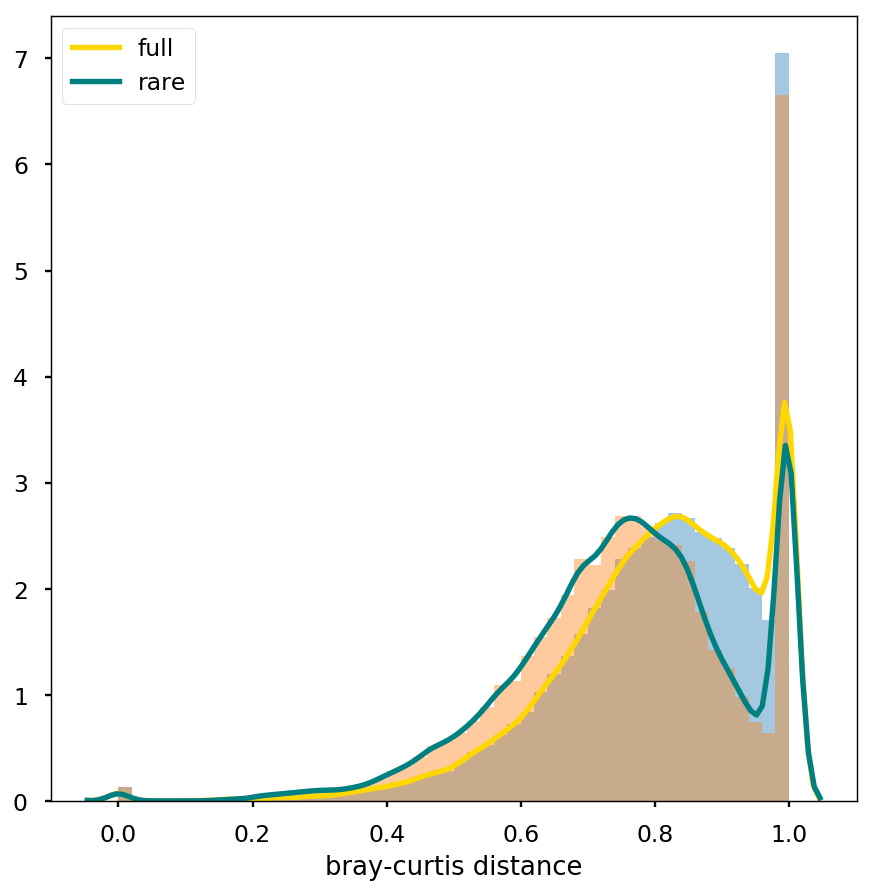

Strict full Strict rare
0.8374390309390155 0.001 370


In [13]:
from skbio.stats import subsample_counts
from skbio.diversity import beta_diversity
import seaborn as sns
from skbio.stats.distance import mantel

def rarefy_table(abund_table, rare_level):
    rare_abund = abund_table.copy() * 0.
    total_abunds = abund_table.sum(1)
    for samp in abund_table.index:
        norm_factor = 1.0
        if total_abunds[samp] < rare_level:
            norm_factor = rare_level / total_abunds[samp]

        select_vect = np.ceil(abund_table.loc[samp, :].values*norm_factor).astype(np.int64)
        rare_vect = subsample_counts(select_vect, int(rare_level))
        rare_abund.loc[samp, :] = rare_vect
    return rare_abund

disttabs = {}
for name_ab, ab_df in abundance_tables.items():
    rare_pp = rarefy_table(ab_df, 3001)
    sample_sums = ab_df.sum(1)
    big_samples = ab_df[sample_sums > 300000].index
    smaller_samples = ab_df[sample_sums < 10000].index
    print(name_ab)
    print("Big samples: {}, Small: {}".format(len(big_samples), len(smaller_samples)))
    plt.clf(); plt.close();
    fixx, axx = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=130)
    cols = ['gold', 'teal']
    labs = ['full', 'rare']
    for ixx, a_table in enumerate([ab_df, rare_pp]):
        bc_dists = beta_diversity("braycurtis", a_table.values, a_table.index)
        disttabs[name_ab + " " + labs[ixx]] = bc_dists
        bc_df = pd.DataFrame(index=a_table.index, columns=a_table.index, data=bc_dists._data)
        print(np.median(bc_df.loc[big_samples, big_samples]), "BvB")
        print(np.median(bc_df.loc[smaller_samples, smaller_samples]), "SvS")
        print(np.median(bc_df.loc[big_samples, smaller_samples]), "BvS")
        sns.distplot(bc_df.values.flatten(), axlabel='bray-curtis distance',
                     kde_kws={"label":labs[ixx], "lw": 3, "color": cols[ixx]}, ax=axx)

    plt.show()

all_mat_names = list(disttabs.keys())
for ix in range(len(all_mat_names)):
    for jx in range(ix+1, len(all_mat_names)):
        print(all_mat_names[ix], all_mat_names[jx])
        r_pp, p_value_pp, n_pp = mantel(disttabs[all_mat_names[ix]], disttabs[all_mat_names[jx]], method='pearson')
        print(r_pp, p_value_pp, n_pp)

#### This calculates the inter-run distances, plots their pdfs, and performs Mann-Whitney U test on each pairing 

e_13 (8944, 1) (26, 344)
e_15_1 (24621, 1) (87, 283)
controls (369, 1) (1, 369)
e_15_2 (19096, 1) (62, 308)
KM (25009, 1) (89, 281)
Miseq_sp (4984, 1) (14, 356)
spr12 (16801, 1) (53, 317)
spr14 (12616, 1) (38, 332)


<Figure size 748.8x514.8 with 0 Axes>

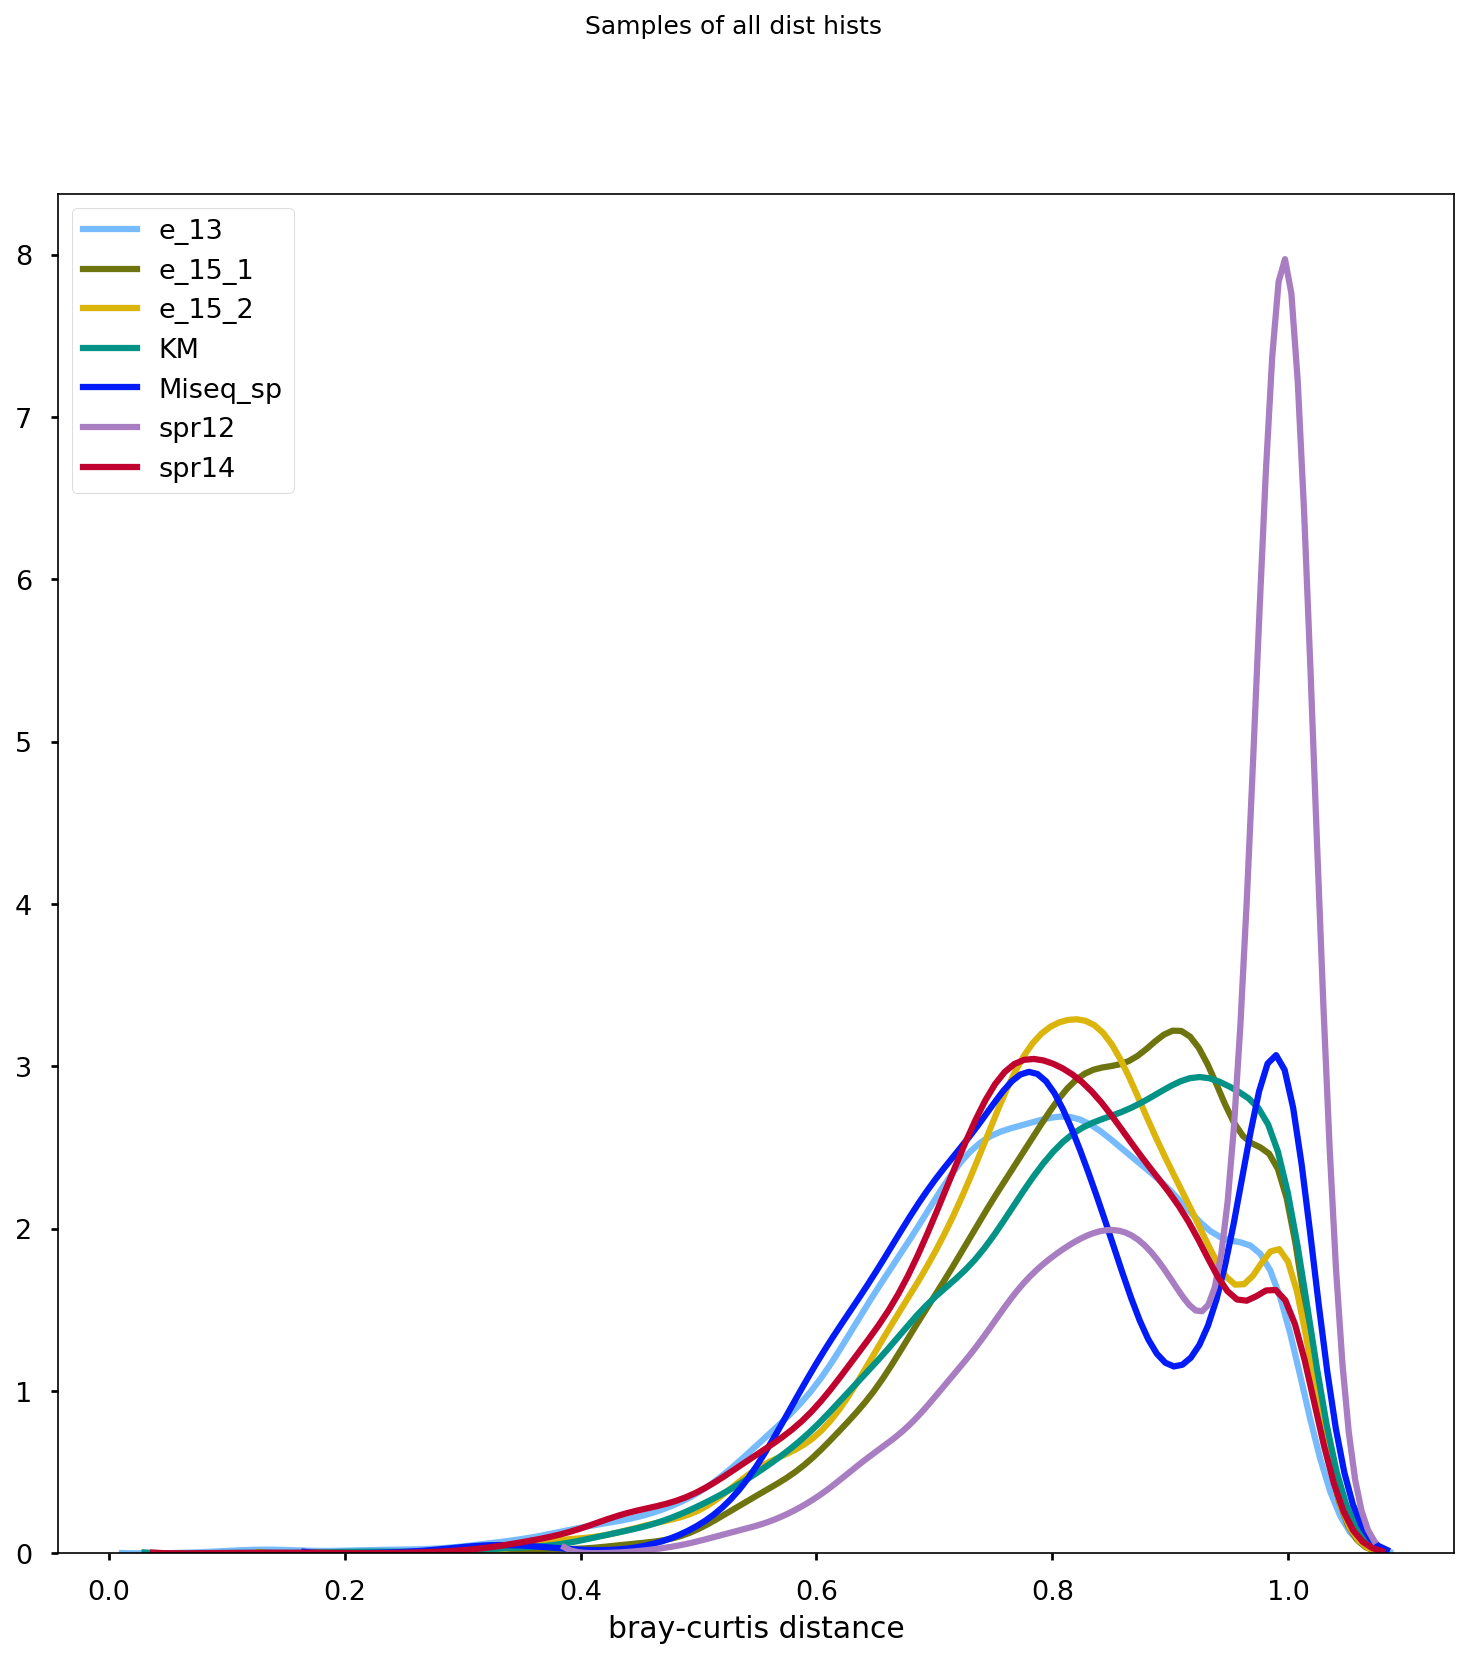

Significance level is 0.0011904761904761906


e_13  e_15_1  e_15_2     KM  Miseq_sp  spr12  spr14
e_13      False    True    True   True      True   True  False
e_15_1     True   False    True  False      True   True   True
e_15_2     True    True   False   True     False   True   True
KM         True   False    True  False      True   True   True
Miseq_sp   True    True   False   True     False   True  False
spr12      True    True    True   True      True  False   True
spr14     False    True    True   True     False   True  False

In [14]:
import seaborn as sns

groups = list(meta_data_df2['sequencing_ID'].unique())

def calculate_group_distance(a_label, a_table):
    # subset according to "in" label 
    in_indexes = meta_data_df2[meta_data_df2['sequencing_ID'] == a_label].index
    
    # subset according to "out" label
    out_group = set(groups) - set([a_label]) 
    out_indexes = meta_data_df2[meta_data_df2['sequencing_ID'].isin(out_group)].index
    assert len(out_indexes) + len(in_indexes) == len(a_table.index)
    
    # calculate bray-curtis for all groups
    bc_dists = beta_diversity("braycurtis", a_table.values, a_table.index)
    bc_df = pd.DataFrame(bc_dists._data, index=a_table.index, columns=a_table.index)
    
    # subset rows by "in" and columns by "out" 
    sub_bcdf = bc_df.loc[in_indexes, out_indexes]
    if sub_bcdf.shape[0] == 1:
        flat_df = sub_bcdf.T
        flat_df.columns = [a_label]
    else:
        flat_df = pd.DataFrame(sub_bcdf.values.flatten(), columns=[a_label])
        
    print(a_label, flat_df.shape, sub_bcdf.shape)
    return (flat_df, flat_df[a_label].mean())

out_data = {}
for a_label in groups:
    out_data[a_label] = calculate_group_distance(a_label, abund_df_og_s1.copy())

_ = out_data.pop('controls'); groups.remove('controls'); 

flat_dfs = pd.DataFrame({l:fdf[l].sample(4000).values for l, (fdf, m) in out_data.items()})

# calculate average distance 

color_choices = ["sky blue", "olive", "gold", "teal", "rich blue", "wisteria", "lipstick red"]

plt.clf()
f, _axes_ = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), dpi=150)
f.suptitle("Samples of all dist hists")
for a_label, cc in zip(groups, color_choices):
    sns.distplot(flat_dfs[a_label], hist=False, axlabel='bray-curtis distance',
                 kde_kws={"label":a_label, 
                          "lw": 3, 
                          "color": sns.xkcd_rgb[cc]}, 
                 ax=_axes_)

plt.legend()
plt.savefig("../otu_data/pca_plots/cross_dists_abthrsh.png", bbox_inches='tight')
plt.show()
plt.clf()
plt.close()

from scipy.stats import mannwhitneyu

pair_tests = pd.DataFrame(index=groups, columns=groups)
for ix in pair_tests.index:
    for cx in pair_tests.columns:
        result = mannwhitneyu(flat_dfs.loc[:, cx].values, flat_dfs.loc[:, ix].values)
        pair_tests.loc[ix, cx] = result[1]*2

sig_level = 0.05/(7*6)
print("Significance level is {}".format(sig_level))
pair_tests < sig_level


#### This creates a plot to show how many OTUs are shared across sequencing runs from the main station (CB33C)

e_13 has 13 libraries
e_15_1 has 9 libraries
e_15_2 has 12 libraries
KM has 38 libraries
Miseq_sp has 14 libraries
spr12 has 53 libraries
spr14 has 12 libraries
475 otus shared across all runs


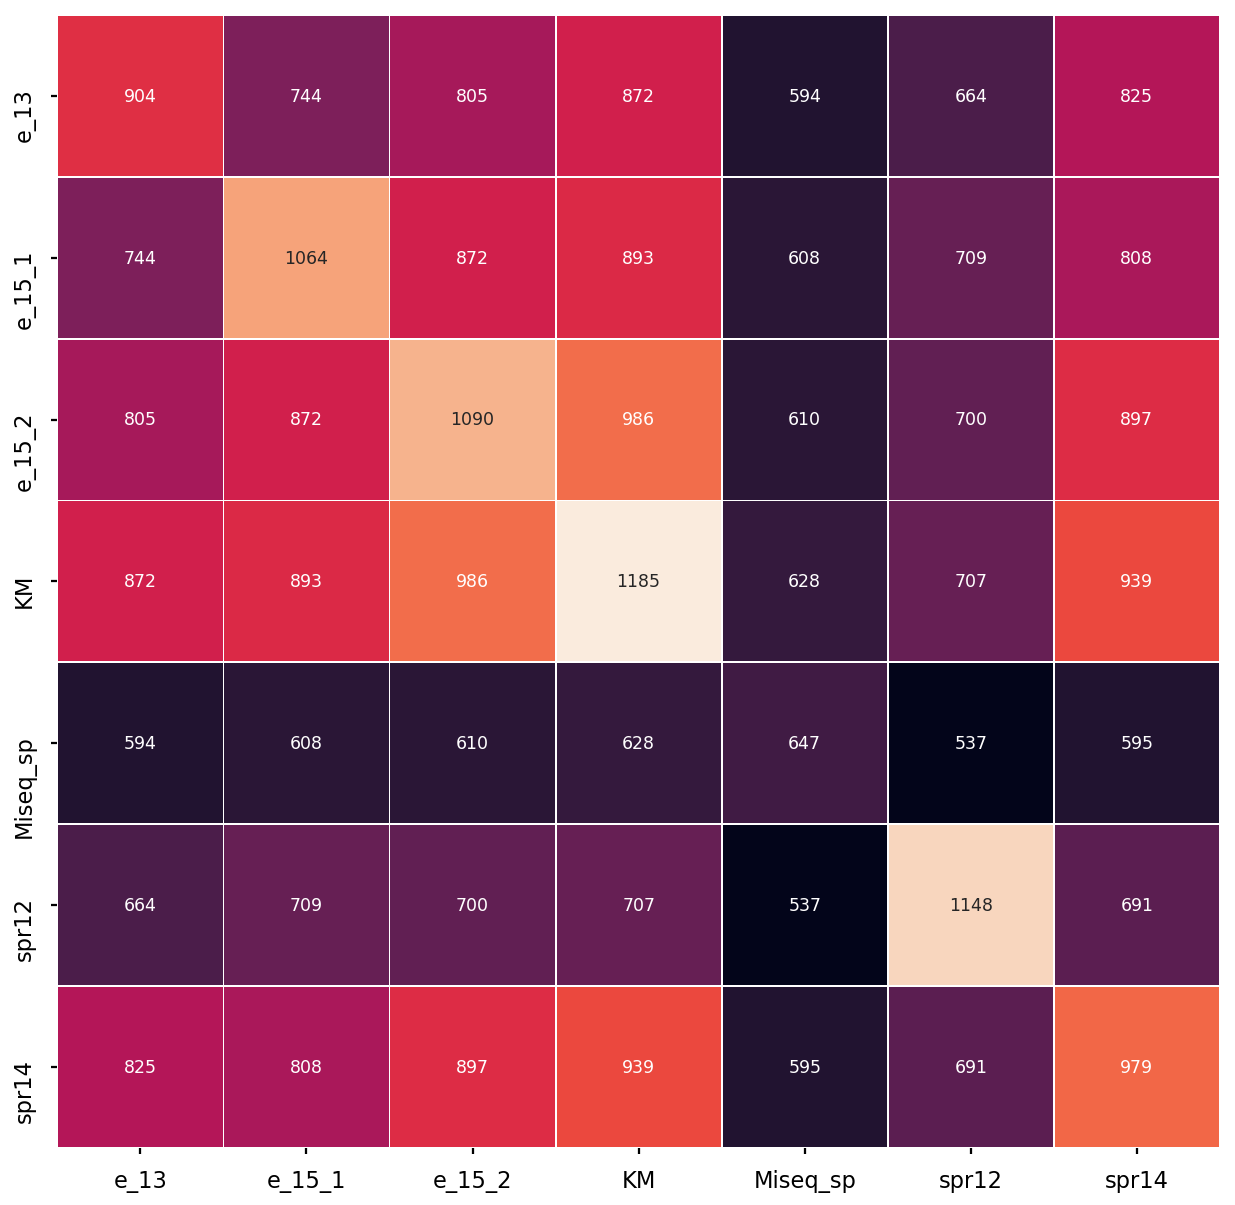

In [15]:
onlycb33 = meta_data_df2.loc[abund_df_og_s1.index, 'StationName'] == 'CB33C'
adf = abund_df_og_s1.loc[onlycb33, :]
mdf = meta_data_df2.loc[adf.index, :]
runs_to_keep = meta_data_df2.loc[adf.index, 'sequencing_ID'].unique()
shared_otus = pd.DataFrame(index=runs_to_keep, columns=runs_to_keep)
shared_group = set(adf.columns)

for run_grp1 in shared_otus.columns:
    rg1_bool = mdf.sequencing_ID == run_grp1
    print("{} has {} libraries".format(run_grp1, rg1_bool.sum()))
    for run_grp2 in shared_otus.index:
        rg2_bool = mdf.sequencing_ID == run_grp2
        otus_in_1 = adf.loc[rg1_bool, :].sum() / rg1_bool.sum()
        otus_in_2 = adf.loc[rg2_bool, :].sum() / rg2_bool.sum()
        foldchange = otus_in_1 / otus_in_2
        num_shared = ((foldchange < 1000) & (foldchange > 0.001)).sum()
        shared_otus.loc[run_grp2, run_grp1] = num_shared
        # optional shared across all groups
        shared_here = foldchange.index[(foldchange < 1000) & (foldchange > 0.001)]
        shared_group = shared_group.intersection(set(shared_here))

print("{} otus shared across all runs".format(len(shared_group)))


plt.clf(); plt.close();
f, _axes_ = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), dpi=125)
sns.heatmap(shared_otus, annot=True, fmt="d", linewidths=.5, ax=_axes_, cbar=False)
plt.savefig("../otu_data/OTU_Overlap_CB33_byRun_abthrsh.png", bbox_inches='tight')
plt.show()
plt.clf(); plt.close();


# Load or make rarefied OTU table & calculate alpha diversity w/bootstraps

In [16]:
from skbio.diversity.alpha import enspie, observed_otus

# need to do rarefaction here
alpha_fn = "../otu_data/alpha_metrics.tsv"
rare_fn = "../otu_data/rarefied_table.tsv"
if os.path.exists(alpha_fn) and os.path.exists(rare_fn):
    alpha_df = pd.read_csv(alpha_fn, sep="\t", index_col=0)
    rare_abund = pd.read_csv(rare_fn, sep="\t", index_col=0)
else:
    print("Calculating alpha diversity metrics and rarefaction table")
    alpha_cols = ['enspie', 'enspie_25', 'enspie_975', 'observed_otus', 'observed_otus_25', 'observed_otus_975']
    alpha_metrics = pd.DataFrame(index=abund_df_og_s1.index, columns=alpha_cols).astype(float)
    rare_abund = abund_df_og_s1 * 0.
    total_abunds = abund_df_og_s1.sum(1)
    rare_level = 3001
    bstrap_cnt = 100
    for s_ix, samp in enumerate(abund_df_og_s1.index):
        enspies, simpson_es, obs_otuses = np.array([0.0]*bstrap_cnt), np.array([0.0]*bstrap_cnt), np.array([0.0]*bstrap_cnt)
        for i in range(bstrap_cnt):
            norm_factor = 1.0
            if total_abunds[samp] < rare_level:
                norm_factor = rare_level / total_abunds[samp]
            
            select_vect = np.ceil(abund_df_og_s1.loc[samp, :].values*norm_factor).astype(np.int64)
            rare_vect = subsample_counts(select_vect, int(rare_level))
            rare_abund.loc[samp, :] = rare_vect
            enspies[i] = enspie(rare_abund.loc[samp, :].values)
            obs_otuses[i] = observed_otus(rare_abund.loc[samp, :].values)
        
        enspies.sort(); obs_otuses.sort();
        for met_name, met_vec in zip(['enspie', "observed_otus"], [enspies, obs_otuses]):
            met_pctiles = np.percentile(met_vec, [2.5, 50, 97.5])
            alpha_metrics.loc[samp, met_name] = met_pctiles[1]
            alpha_metrics.loc[samp, met_name+'_25'] = met_pctiles[1] - met_pctiles[0]
            alpha_metrics.loc[samp, met_name+'_975'] = met_pctiles[2] - met_pctiles[1]

        print("Completion percent {:.2%}".format((s_ix+1)/abund_df_og_s1.shape[0]), sep=' ', end="\r", flush=True)
        
    alpha_metrics.to_csv(alpha_fn, sep="\t")
    rare_abund.to_csv(rare_fn, sep="\t")
    print("Writing alpha metrics ({1}) and rarefied abundances ({0}) to file".format(rare_abund.shape,
                                                                                     alpha_df.shape))
    alpha_df = alpha_metrics.copy()


#### Read in water quality data

In [17]:
melted_file = "../otu_data/WaterQualityData/melted_wq_07to17.tsv"
if not os.path.exists(melted_file):
    db_file = "../otu_data/WaterQualityData/WaterQualityData_07to17.tsv"
    df_raw = pd.read_csv(db_file, sep="\t", parse_dates=[['SampleDate', 'SampleTime']], low_memory=False)
    df_nn = df_raw[df_raw.MeasureValue.notnull()]
    df_nn['SampleDate_SampleTime'] = df_nn.SampleDate_SampleTime.apply(pd.to_datetime)
    summer_idxs = set()
    for yr_i, yr in enumerate(range(2012,2018)):
        left_side = pd.to_datetime(str(yr)+'-03-15')
        right_side = pd.to_datetime(str(yr)+'-10-15')
        date_range_ = (df_nn.SampleDate_SampleTime >= left_side) & (df_nn.SampleDate_SampleTime < right_side)
        summer_idxs.update(df_nn[date_range_].index)
        print("Window {} is {} to {}, grabbed {} total".format(yr_i, left_side, right_side, len(summer_idxs)))

    df_nv = df_nn.loc[summer_idxs, :]
    df_nv.loc[df_nv.Problem == 'NV', 'Problem'] = np.nan
    df_nv.loc[df_nv.Problem == 'QQ', 'Problem'] = np.nan
    df_nv.loc[df_nv.Problem == 'WW', 'Problem'] = np.nan
    df_np = df_nv[df_nv.Problem.isnull()]

    needed_cols = ['TotalDepth', 'UpperPycnocline', 'LowerPycnocline']
    idx_cols = ["SampleDate_SampleTime", "Station", "Depth"]
    new_df = pd.pivot_table(data = df_np, index = idx_cols, columns = 'Parameter', 
                            values = 'MeasureValue', aggfunc=np.mean).sort_index()

    addl_cols = df_np.loc[:, idx_cols+needed_cols].groupby(idx_cols).agg(np.mean).sort_index()
    wq_melted = new_df.join(addl_cols)
    wq_melted.to_csv(melted_file, sep="\t")
else:
    print("Reading melted water quality data from file")
    wq_melted_df = pd.read_csv(melted_file, sep="\t")
    print("Df size {}".format(wq_melted_df.shape))
    print("First index: ", wq_melted_df.iloc[0, :3].values, "\nLast Index: ", wq_melted_df.iloc[-1, :3].values)
    print(wq_melted_df.isnull().sum().sort_values())

Reading melted water quality data from file
Df size (21957, 37)
First index:  ['2012-03-16 10:50:00' 'CB7.4' 0.0] 
Last Index:  ['2017-09-27 11:18:00' 'CB2.1' 5.0]
SampleDate_SampleTime        0
Station                      0
Depth                        0
TotalDepth                   8
PH                        1024
WTEMP                     1025
SPCOND                    1068
SALINITY                  1068
DO                        1069
SIGMA_T                   1069
UpperPycnocline           6136
LowerPycnocline           6136
PO4F                     17998
TDN                      18001
PC                       18002
PP                       18003
NO23F                    18005
PN                       18005
NO3F                     18005
NO2F                     18005
TDP                      18006
DOP                      18006
TSS                      18014
CHLA                     18015
PHEO                     18015
NH4F                     18018
DIN                      18024

# Get actual pycnocline locations

In [18]:
def date1(x):
    a = [float(i) for i in x.split()[0].split("-")]
    return a[0] + a[1]/12 + a[2]/(365.3333)

def date2(a):
    return float(a[:2])/(12) + float(a[2:4])/(365.3333) + (float(a[4:])+2000)

super_matched = super_df.copy()[super_df.DepthName != 'LAB']
wq_melted_df['date_float'] = pd.to_datetime(wq_melted_df['SampleDate_SampleTime']).astype(np.int64) // 10**9
super_matched['date_float'] = pd.to_datetime(super_matched['DateMMDDYY'], format="%m%d%y").astype(np.int64) // 10**9
super_matched['SpaceTime'] = super_matched.loc[:, ['DateMMDDYY', 'date_float', 'StationName']].apply(tuple, axis=1)

isint = lambda x: True if x%1.0 == 0 else False
water_nzd = wq_melted_df[(wq_melted_df.Depth != 0) & wq_melted_df.Depth.apply(isint)]

idx_names = ['DateMMDDYY', 'date_float', 'StationName']
wqm_idx = pd.MultiIndex.from_tuples([tuple(i) for i in super_matched.SpaceTime.unique()], names=idx_names)
wqm_df = pd.DataFrame(index=wqm_idx, columns=['DensityMatchDate', 'DensityTimeDelta',
                                              'PycDepth', 'BVF', 'FoldChange']).sort_index()

density_profiles = []

for sd_x in wqm_df.index:
    mdy_t, ux_t, stat_ = sd_x
    stat_mod = stat_[:3] +"." + stat_[3:5]
    stat_select = water_nzd[water_nzd.Station == stat_mod]
    #print(stat_mod, mdy_t, stat_select.shape)
    donebool = False
    timediff = abs(stat_select.date_float - ux_t) / (24*60**2)
    while not donebool:
        matched_time, time_delt = timediff.idxmin(), timediff.min()
        selected_time = stat_select.loc[matched_time, 'SampleDate_SampleTime']
        time_select = stat_select[stat_select.SampleDate_SampleTime == selected_time]
        #print(selected_time, mdy_t, time_select.shape)
        select_densities = time_select.sort_values(['Depth']).loc[:, ['Depth', 'SIGMA_T']]
        depth_gradient = np.gradient(select_densities.SIGMA_T.values, select_densities.Depth.values)
        select_densities['BVF'] = pd.Series(depth_gradient, index=select_densities.index)
        select_densities = select_densities[select_densities.Depth > 2.0]
        if select_densities.BVF.isnull().sum() > 2:
            print("bad date")
            donebool = True
            timediff = timediff[timediff > time_delt]
        else:
            donebool = True
            wqm_df.loc[sd_x, 'PycDepth'] = select_densities.loc[select_densities['BVF'].idxmax(), 'Depth']
            wqm_df.loc[sd_x, 'BVF'] = select_densities.loc[select_densities['BVF'].idxmax(), 'BVF']
            wqm_df.loc[sd_x, 'FoldChange'] = wqm_df.loc[sd_x, 'BVF']/np.median(select_densities['BVF'])
            wqm_df.loc[sd_x, 'DensityMatchDate'] = selected_time
            wqm_df.loc[sd_x, 'DensityTimeDelta'] = time_delt
            density_profiles.append(select_densities.copy())


"""
# maybe make date distance threshold harsher
# get precipitation and windspeed data to confirm
# should make options for upper/lower water column w/o stratification
"""

for new_var in ['Pycnocline', 'dSigmaT_dDepth', 'PycDepth']:
    super_matched[new_var] = pd.Series([np.nan]*super_matched.shape[0], index=super_matched.index)

wqm_df = wqm_df[wqm_df.DensityTimeDelta < 5]
wqm_df = wqm_df[wqm_df.FoldChange.notnull()]
wqm_df = wqm_df[wqm_df.FoldChange > 3]


for dat_MDY, date_flt, statn in wqm_df.index:
    #print(tuple([dat_MDY, date_flt, statn]))
    this_depth = wqm_df.PycDepth[tuple([dat_MDY, date_flt, statn])]
    this_bvf = wqm_df.BVF[tuple([dat_MDY, date_flt, statn])]
    dat_bool = super_matched['DateMMDDYY'] == dat_MDY
    dflt_bool = super_matched['date_float'] == date_flt 
    stat_bool = super_matched['StationName'] == statn
    above_bool = super_matched['DepthName'].astype(int) <= this_depth
    below_bool = super_matched['DepthName'].astype(int) > this_depth
    super_matched.loc[dat_bool & dflt_bool & stat_bool & above_bool, 'Pycnocline'] = 'Above'
    super_matched.loc[dat_bool & dflt_bool & stat_bool & below_bool, 'Pycnocline'] = 'Below'
    super_matched.loc[dat_bool & dflt_bool & stat_bool, 'PycDepth'] = this_depth
    super_matched.loc[dat_bool & dflt_bool & stat_bool, 'dSigmaT_dDepth'] = this_bvf



bad date
bad date
bad date


#### Look at results of density gradient calculations 

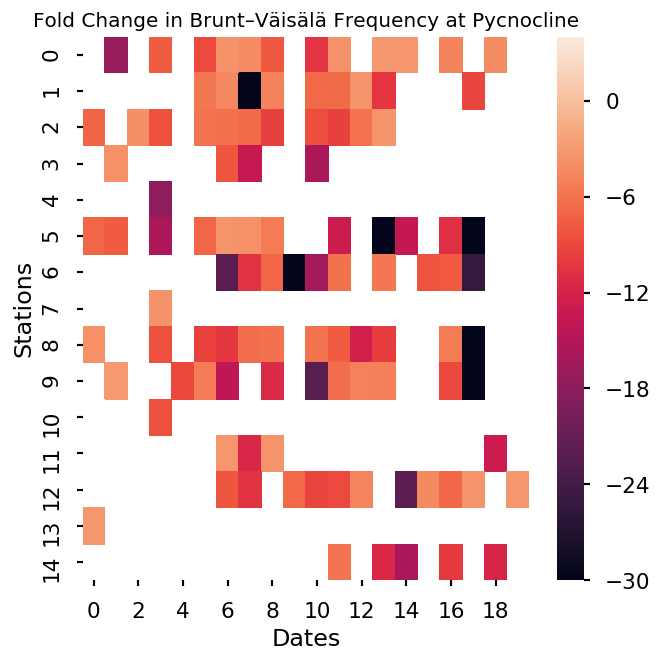

In [19]:
wqm_df_full = wqm_df.reset_index()
wqm_df_full['FoldChange'] = wqm_df_full['FoldChange'].astype(float)
wqm_df_full['StatEncoded'] = wqm_df_full.loc[:, 'StationName'].map(metas_ls['encoding']['StationName'])
wqm_df_full['DatEncoded'] = wqm_df_full.loc[:, 'DateMMDDYY'].map(metas_ls['encoding']['DateMMDDYY'])

wqm_pivot = pd.pivot_table(wqm_df_full, columns=['StatEncoded'], values=['FoldChange'], 
                           index=['DatEncoded'], fill_value=-1.)

mask = np.zeros_like(wqm_pivot.values)
mask[wqm_pivot.values == -1.] = True
fc_fig, fc_ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=120)
ax_fc = sns.heatmap(wqm_pivot.values*-1, mask=mask, vmin=-30, vmax=4, ax=fc_ax)
ax_fc.set_title('Fold Change in Brunt–Väisälä Frequency at Pycnocline', fontsize=12)
ax_fc.set(xlabel='Dates', ylabel='Stations')
plt.show()

#### Add Bray Curtis Distance to Columns

In [20]:
abund_s1_exp_pre = abund_df_og_s1.loc[super_matched.index, :]
abund_s1_exp = abund_s1_exp_pre.div(abund_s1_exp_pre.sum(1), axis=0)
s1_bc = beta_diversity("braycurtis", abund_s1_exp.values, abund_s1_exp.index)._data
s1_bc_df = pd.DataFrame(s1_bc, index=abund_s1_exp.index,
                       columns=[i+"_bc" for i in abund_s1_exp.index])
s1_corr = beta_diversity("correlation", abund_s1_exp.values, abund_s1_exp.index)._data
s1_corr_df = pd.DataFrame(s1_corr, index=abund_s1_exp.index,
                          columns=[i+"_corr" for i in abund_s1_exp.index])

abund_md_df = super_matched.join(s1_bc_df).join(s1_corr_df)
print(super_matched.shape)
print(abund_md_df.shape)

(364, 2001)
(364, 2729)


# add all the rest of the sample data

43 potential replicates


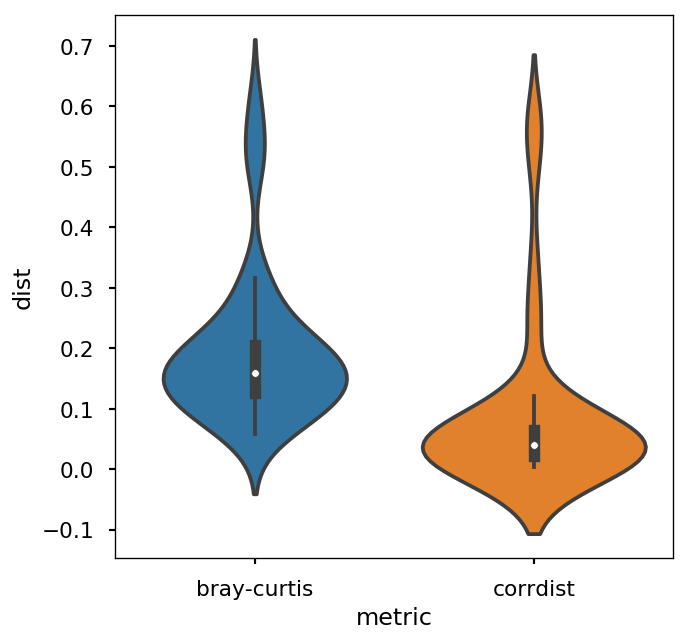

(321, 2730) (364, 2730)


In [21]:
# fix some station mislabellings back 
true_surf = [i for i in abund_md_df.index if 'CD0BR' in i]
abund_md_df.loc[true_surf, 'DepthName'] = '00'

# add salinity group
sal_dict = {"Oligohaline": ['CB22', 'CB31'],
            "Mesohaline": ['CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54'],
            "Polyhaline": ['CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74']}

for sal_i, stat_ls in sal_dict.items():
    abund_md_df.loc[abund_md_df.StationName.isin(stat_ls), 'Salinity_Group'] = sal_i

# add replicate column
abund_md_df['replicate'] = pd.Series(pd.Categorical([1]*abund_md_df.shape[0], categories=[1,2,3]), 
                                     index=abund_md_df.index)

st_cols = ['DateMMDDYY', 'DepthName', 'StationName']
abund_md_df.loc[:, 'SpaceTime'] = abund_md_df.loc[:, st_cols].apply(tuple, axis=1)
unq_tds = abund_md_df.SpaceTime.unique()
print("{} potential replicates".format(abund_md_df.shape[0] - unq_tds.shape[0]))

bc_col_pairs, corr_col_pairs = [], []
for (t_, d_, s_) in abund_md_df.SpaceTime.unique():
    mxO = abund_md_df[abund_md_df['SpaceTime'] == (t_, d_, s_)].index
    if len(mxO) != 1:
        pert_cols = [i for i in abund_md_df.columns if i.split("_")[0] in list(mxO)]
#        sub_dists = abund_md_df.loc[mxO, pert_cols].values.flatten()
#        if (sub_dists > 0.3).sum() > 0:
#            print(abund_md_df.loc[mxO, some_columns])
#            print(abund_md_df.loc[mxO, pert_cols].values)
        for num_r, ix_ in enumerate(mxO):
            for pc in pert_cols:
                if not ix_ in pc and not "_bc" in pc:
                    corr_col_pairs.append((ix_, pc))
                elif not ix_ in pc and not "_corr" in pc:
                    bc_col_pairs.append((ix_, pc))
            
            abund_md_df.loc[ix_, 'replicate'] = num_r+1 

bc_rep_vals = np.array([abund_md_df.loc[i, j] for i, j in bc_col_pairs], dtype=float)
corr_rep_vals = np.array([abund_md_df.loc[i, j] for i, j in corr_col_pairs], dtype=float)
rep_dists = np.hstack((bc_rep_vals, corr_rep_vals))
rep_names = np.array(['bray-curtis']*97 + ['corrdist']*97)
rep_dist_df = pd.DataFrame(np.vstack((rep_names, rep_dists)).T, columns=['metric', 'dist'])
rep_dist_df.loc[:, 'metric'] = rep_dist_df.loc[:, 'metric'].astype('category')
rep_dist_df.loc[:, 'dist'] = rep_dist_df.loc[:, 'dist'].astype('float')

plt.clf(); plt.close();
figrep, axrep = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=120)
ax = sns.violinplot(y="dist", x="metric", data=rep_dist_df, ax=axrep)
plt.show()

abund_md_df_derep = abund_md_df[abund_md_df.replicate == 1]
print(abund_md_df_derep.shape, abund_md_df.shape)


# Figure 2: Hierarchical Clustering of Principal Components w/ Metadata 

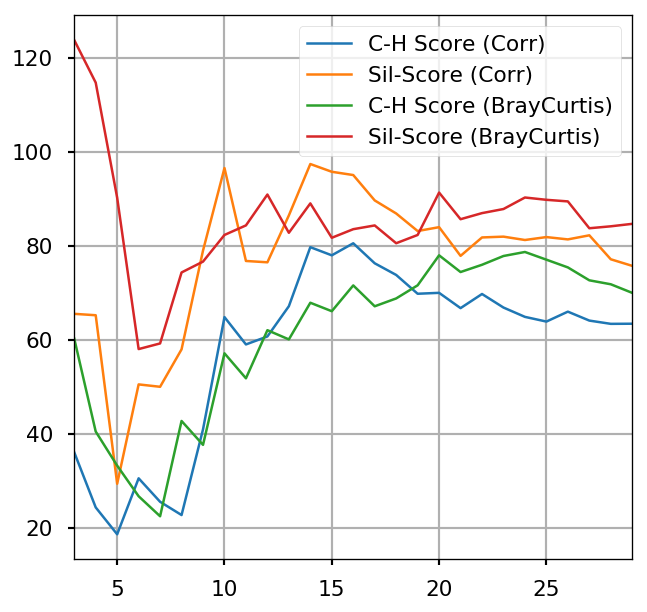

C-H Score (Corr) 16
Sil-Score (Corr) 14
C-H Score (BrayCurtis) 24
Sil-Score (BrayCurtis) 3


In [53]:
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# There are two ways of doing this: using rclr+pca or just feeding in relative abundances
exp_abunds = abund_md_df_derep.loc[:, abund_df_og_s1.columns]

"""
rclr_mat = rclr().fit_transform(exp_abunds.values + 0.1)

#n_comps = 10
#model = PCA(n_components=n_comps, svd_solver='randomized', random_state=42)
model.fit(rclr_mat)
rclr_projected = model.transform(rclr_mat)
pc_df = pd.DataFrame(index=exp_abunds.index, data=rclr_projected)
print(pc_df.shape)


figpca, axpca = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120)
axpca.bar(range(1, 1+n_comps), model.explained_variance_ratio_, alpha=0.5, align='center',
        label='individual explained variance')
axpca.step(range(1, 1+n_comps), np.cumsum(model.explained_variance_ratio_), where='mid',
         label='cumulative explained variance')
axpca.set(ylabel='Explained variance ratio', xlabel='Principal components')
plt.tight_layout()
plt.show()
"""
corr_cols = [i for i in abund_md_df_derep.columns if "_corr" in i and i[:-5] in abund_md_df_derep.index]
bc_cols = [i for i in abund_md_df_derep.columns if "_bc" in i and i[:-3] in abund_md_df_derep.index]

assert len(corr_cols) == len(abund_md_df_derep.index) == len(bc_cols)

for i, j, k in zip(pc_df.index, corr_cols, bc_cols):
    assert i == j[:-5] == k[:-3]
    
relAbunds_corr = abund_md_df_derep.loc[:, corr_cols]
relAbunds_bc = abund_md_df_derep.loc[:, bc_cols]

score_cols = ['C-H Score (Corr)', 'Sil-Score (Corr)', 'C-H Score (BrayCurtis)', 'Sil-Score (BrayCurtis)']
clust_num_range = list(range(3,30))
clust_scores = pd.DataFrame(index=clust_num_range, columns=score_cols).astype(float)

for n_clusters_ in clust_num_range:
    cluster_mod1 = AgglomerativeClustering(n_clusters=n_clusters_, affinity='precomputed', linkage='average') 
    cluster_mod2 = AgglomerativeClustering(n_clusters=n_clusters_, affinity='precomputed', linkage='average') 
    
    cluster_labels1 = cluster_mod1.fit_predict(relAbunds_corr.values)
    cluster_labels2 = cluster_mod2.fit_predict(relAbunds_bc.values)
    
    clust_scores.loc[n_clusters_, score_cols[0]] = metrics.calinski_harabaz_score(relAbunds_corr.values, 
                                                                                  cluster_labels1)
    clust_scores.loc[n_clusters_, score_cols[1]] = metrics.silhouette_score(relAbunds_corr.values, 
                                                                            cluster_labels1)*300
    clust_scores.loc[n_clusters_, score_cols[2]] = metrics.calinski_harabaz_score(relAbunds_bc.values, 
                                                                                   cluster_labels2)
    clust_scores.loc[n_clusters_, score_cols[3]] = metrics.silhouette_score(relAbunds_bc.values, 
                                                                            cluster_labels2)*300



fig_cscore, ax_cscore = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), dpi=120)
clust_scores.plot(ax=ax_cscore)
plt.grid()
plt.show()
for sc in score_cols:
    print(sc, clust_scores[sc].idxmax())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15} [ 0  1  2  4  5  6  7  8 12]
0
1
2
4
5
6
7
8
12


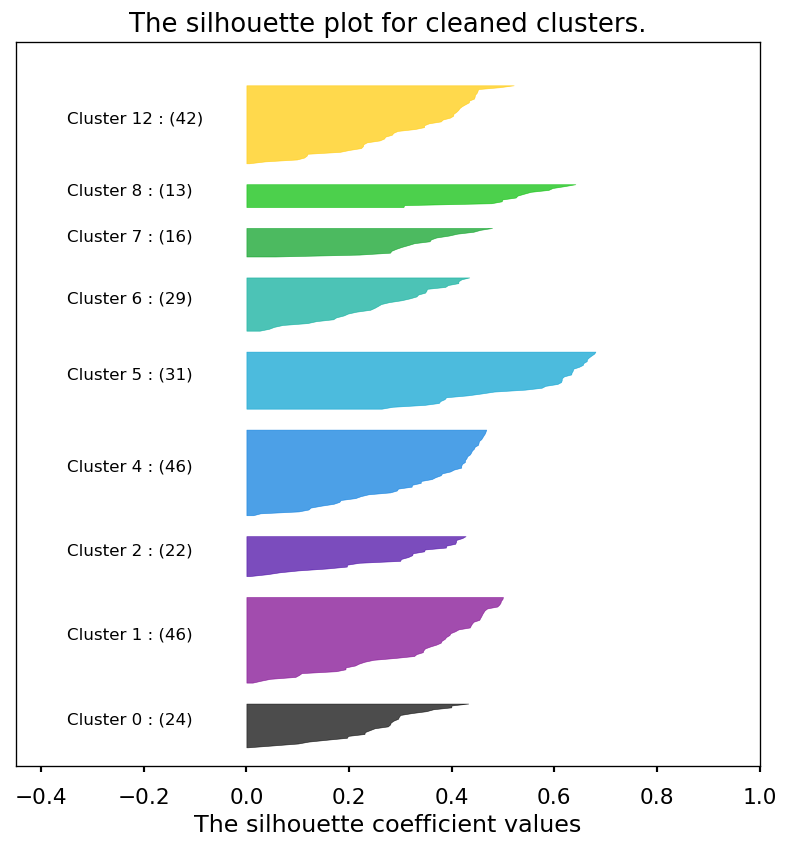

In [34]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Pick out the four biggest clusters 
n_clusters = 16
best_mod = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average') 

cluster_labels = best_mod.fit_predict(relAbunds_exp.values)
sample_silhouette_values = silhouette_samples(relAbunds_exp.values, cluster_labels)
positive_idxs = relAbunds_exp.index[sample_silhouette_values > 0]
positive_silhouettes = sample_silhouette_values[sample_silhouette_values > 0]
positive_labels = cluster_labels[sample_silhouette_values > 0]

label_counts = np.unique(positive_labels, return_counts=1)

good_clusts = label_counts[0][label_counts[1] > 10]
print(set(cluster_labels), good_clusts)

fig, ax1 = plt.subplots(nrows=1, ncols=1, dpi=120)
fig.set_size_inches(8, 8)
ax1.set_xlim([-.45, 1])
ax1.set_ylim([0, len(relAbunds_exp.values) + ((1+len(good_clusts))* 6) ])
y_lower = 10

clean_clusts = {}
for i in good_clusts:
    print(i)
    ith_cluster_silhouette_values = positive_silhouettes[positive_labels == i]
    clean_clusts[i] = positive_idxs[positive_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.35, y_lower + 0.5 * size_cluster_i, "Cluster {} : ({})".format(i, size_cluster_i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for cleaned clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.get_yaxis().set_visible(False)



optimal minimum cophenetic distance is 0.5415


<Figure size 748.8x514.8 with 0 Axes>

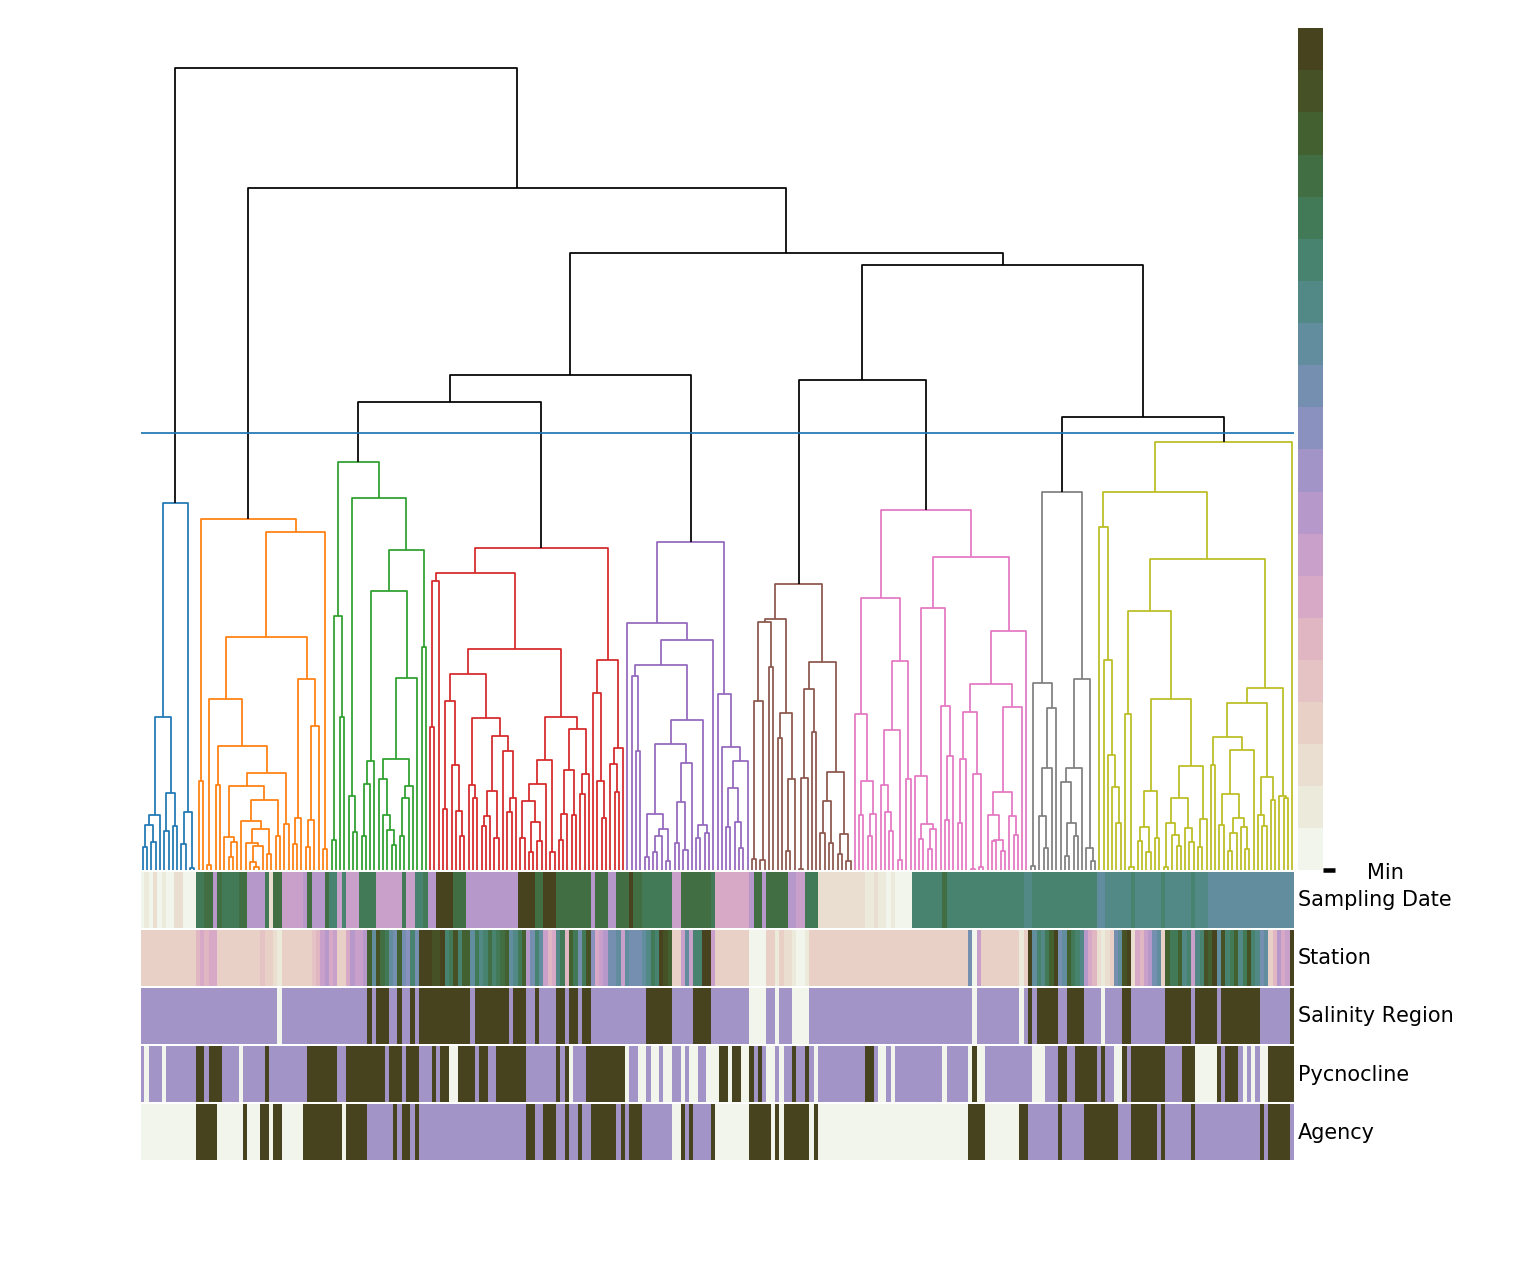

In [35]:
from scipy.cluster import hierarchy
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import scipy.spatial.distance as ssd
import matplotlib.gridspec as gridspec

# There are optimally either 4-5 or 14-16 clusters depending on how you make them
clean_labs = [j for i in clean_clusts.values() for j in i]
ordered_index = [i for i in relAbunds_exp.index if i in clean_labs]
ordered_columns = [i for i in relAbunds_exp.columns if i[:-5] in clean_labs]
cleaned_df = relAbunds_exp.loc[ordered_index, ordered_columns]
sqmat = ssd.squareform(cleaned_df.values)

opt_clusts = 9
plt.clf()
# Override the default linewidth.
matplotlib.rcParams['lines.linewidth'] = 0.5
Z = hierarchy.linkage(sqmat, 'average', optimal_ordering=True)
fig_ = plt.figure(figsize=(7, 6), dpi=250)
gs = gridspec.GridSpec(6, 4, figure=fig_, wspace=0.01, hspace=0.01, 
                       height_ratios=[75,5,5,5,5,5], width_ratios=[18,.4,1.3,1.3])
ax1 = plt.subplot(gs[0,0])


#for c_height in np.arange(0.3,1.0, 0.0005):
#    cuttree = hierarchy.cut_tree(Z, height=[c_height])
#    if len(set(list(cuttree[:, 0]))) <= opt_clusts:
#        break

c_height = 0.5415

print("optimal minimum cophenetic distance is {}".format(c_height))
hierarchy.set_link_color_palette(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                  'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
                                  'tab:olive', 'tab:cyan'])

res = hierarchy.dendrogram(Z, color_threshold=c_height*1.02, get_leaves=True, 
                           ax=ax1, labels=cleaned_df.index, no_labels=True, 
                           above_threshold_color='k')
ax1.axhline(y=c_height*1.02)
ax1.axis('off')
matplotlib.rcParams['lines.linewidth'] = 1.5

# get axis order
new_idx = cleaned_df.index[res['leaves']]
# metadata columns to plot
sel_md_cols = ['Month_Year', 'StationName', 'Pycnocline', 'Salinity_Group', 'sequencing ID',
              'CollectionAgency']
# resort metadata
clustered_metadata = abund_md_df_derep.loc[new_idx, sel_md_cols].copy()
# encode colors and reverse
color_codings = [{1:'06 15', 2:'07 15', 3:'08 15', 7:'06 16', 8:'07 16', 9:'08 16', 
                  13:'04 17', 14:'05 17', 15:'06 17', 16:'07 17', 17:'08 17', 20:'09 17'},
                 {4:'CB33C', 1:'CB22', 5:'CB41C', 7:'CB43C', 8:'CB44', 9:'CB51', 10:'CB52', 
                  11:'CB53', 12:'CB54', 17:'CB71', 14:'CB62', 15:'CB63', 18:'CB72', 16:'CB64', 
                  20:'CB74', 2:'CB31', 3:'CB32', 6:'CB42C', 13:'CB61', 19:'CB73'},
                 {1:'Above', 20:'Below', 10:np.nan}, {10:'Mesohaline', 1:'Oligohaline', 20:'Polyhaline'},
                 {1:'sprehei1_123382', 4:'Miseq_data_SarahPreheim_Sept2016', 7:'esakows1_132789', 
                  10:'Keith_Maeve1_138650', 13:'sprehei1_149186', 17:'esakows1_152133_plate_1', 
                  20:'esakows1_152133_plate_2'}, {1:"Preheim", 10:"ODU", 20:"DNR"}]

rev_col_codes = []
for x in color_codings:
    rev_col_codes.append({j:i for i, j in x.items()})

# map encodings
for sdc, cmapping in zip(sel_md_cols, rev_col_codes):
    clustered_metadata[sdc] = clustered_metadata[sdc].map(cmapping)

# select palette with max # of categories
#all_col_pal = sns.color_palette("cubehelix_r", clustered_metadata.max().max())
all_col_pal = sns.cubehelix_palette(n_colors=clustered_metadata.max().max(), start=.3, rot=1.5, gamma=1.0,
                                    hue=0.7, light=0.95, dark=0.25, reverse=0)
cmap_ = LinearSegmentedColormap.from_list('Custom', tuple(all_col_pal), len(tuple(all_col_pal)))

mdata_nrow = clustered_metadata.shape[0]
# plot first row and bar
ax2 = plt.subplot(gs[1,0])
ax2l = plt.subplot(gs[1,1:])
ax2_vals = clustered_metadata['Month_Year'].values.reshape(mdata_nrow,1).T
sns.heatmap(ax2_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax2)
ax2l.text(0.,0.4, "Sampling Date", fontdict={'fontsize':6})
ax2.axis('off'); ax2l.axis('off');

ax4 = plt.subplot(gs[2,0])
ax3 = plt.subplot(gs[0,1])
ax4_vals = clustered_metadata['StationName'].values.reshape(mdata_nrow,1).T
stat_ax = sns.heatmap(ax4_vals, linewidths=0.0, cmap=cmap_, cbar=True, cbar_ax=ax3, xticklabels=False, yticklabels=False, ax=ax4)
cb = stat_ax.collections[0].colorbar
cb.ax.tick_params(labelsize=6);
cb.set_ticks([1, 20]); cb.set_ticklabels(['Min', 'Max']); 
ax4l = plt.subplot(gs[2,1:])
ax4l.text(0.,0.4, "Station", fontdict={'fontsize':6})
ax4.axis('off'); ax4l.axis('off');

ax6 = plt.subplot(gs[3,0])
ax6l = plt.subplot(gs[3,1:])
ax6_vals = clustered_metadata['Salinity_Group'].values.reshape(mdata_nrow,1).T
sns.heatmap(ax6_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax6)
ax6l.text(0.,0.4, "Salinity Region", fontdict={'fontsize':6})
ax6.axis('off'); ax6l.axis('off');

ax7 = plt.subplot(gs[4,0])
ax7l = plt.subplot(gs[4,1:])
ax7_vals = clustered_metadata["Pycnocline"].values.reshape(mdata_nrow,1).T
sns.heatmap(ax7_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax7)
ax7l.text(0.,0.4, "Pycnocline", fontdict={'fontsize':6})
ax7.axis('off'); ax7l.axis('off');

ax8 = plt.subplot(gs[5,0])
ax8l = plt.subplot(gs[5,1:])
ax8_vals = clustered_metadata["CollectionAgency"].values.reshape(mdata_nrow,1).T
sns.heatmap(ax8_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax8)
ax8l.text(0.,0.4, "Agency", fontdict={'fontsize':6})
ax8.axis('off'); ax8l.axis('off');

fig_.savefig('../otu_data/pca_plots/pca_of_corrdist_avlinkage_clusters_5mdata_clean.png', dpi=250)


In [36]:
clust_lab_map = {mem_i:"Cluster "+ f"{clab:02}" for clab, cmems in clean_clusts.items() for mem_i in cmems}
temp_amdf = abund_md_df_derep.loc[ordered_index, :].reset_index()
temp_amdf['Cluster Label'] = temp_amdf['Samples'].map(clust_lab_map)
ab_md_df_dr_cl = temp_amdf.set_index('Samples')
cols_to_group = list(abund_df_og_s1.columns)+['Cluster Label']
ab_df_dr_cl = ab_md_df_dr_cl.loc[:, cols_to_group]
cluster_sums = ab_df_dr_cl.groupby('Cluster Label').agg(np.mean).sort_index()
cluster_sums.sum(1)

Cluster Label
Cluster 00    110068.708333
Cluster 01    122205.108696
Cluster 02     81857.409091
Cluster 04    105122.413043
Cluster 05    134780.096774
Cluster 06    178651.689655
Cluster 07    138074.375000
Cluster 08     33011.153846
Cluster 12     77029.619048
dtype: float64

(9, 145)
The collapsed taxa table is (9, 44)
44 colors grabbed


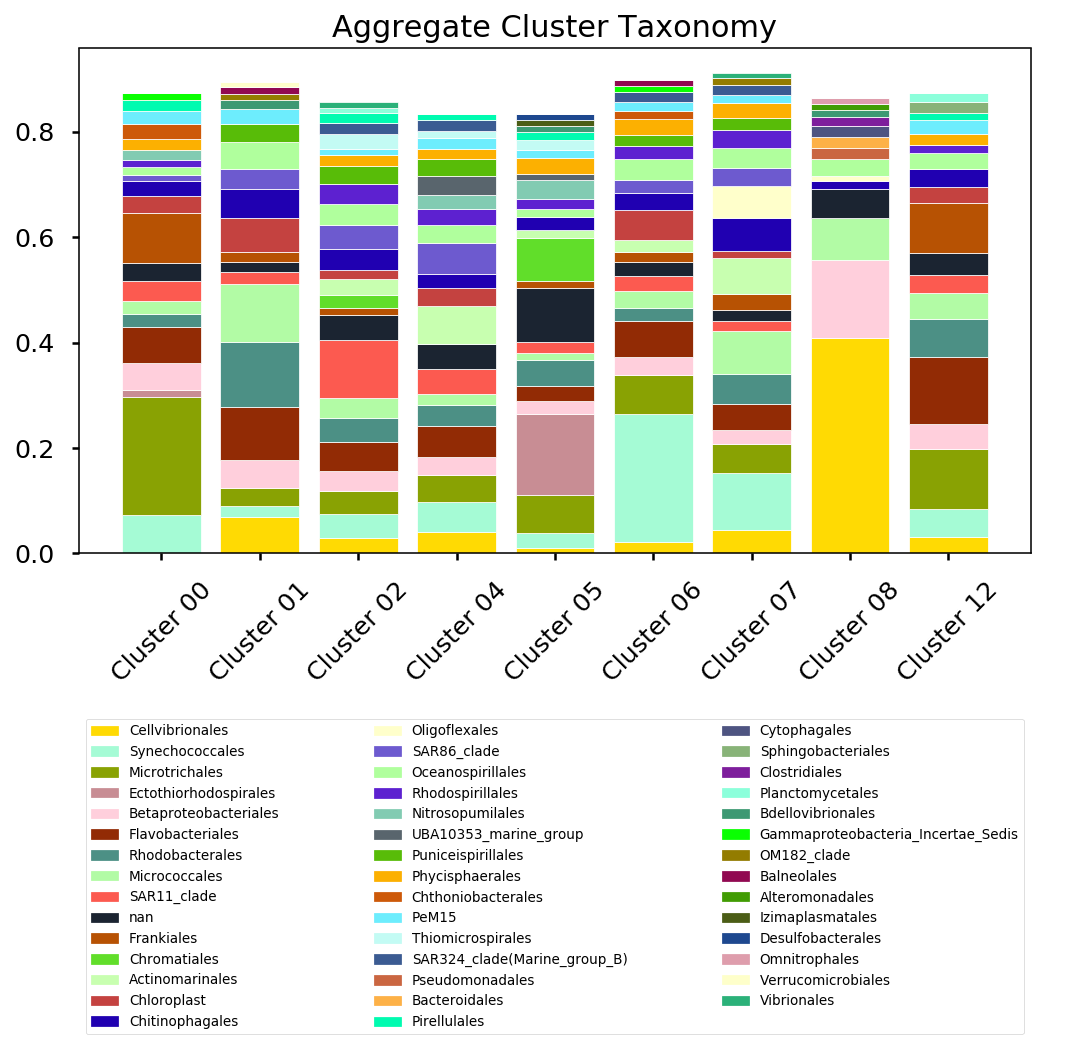

Saving TaxaClusters_avg.png


In [37]:
def taxa_breakdown(abunds_, taxas_, level_, weighted=True, flatten_val=0.0):
    # 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'
    # remove non-existant features
    flip_abunds = abunds_.loc[:, abunds_.sum(0) > 0].T
    # create presence or absence table if need be
    if not weighted:
        flip_abunds = (flip_abunds > 0).astype(int)
    # add level column
    otu_fetch = lambda x: taxas_.loc[x, level_]
    flip_abunds['otu_name'] = flip_abunds.index
    flip_abunds['taxa_name'] = flip_abunds['otu_name'].apply(otu_fetch)
    flip_abunds.drop('otu_name', axis=1, inplace=True)
    ttable_raw = flip_abunds.groupby('taxa_name').agg(np.sum)
    ttable = ttable_raw.div(ttable_raw.sum(0))
    if flatten_val:
        flat_ttv = ttable.values
        flat_ttv[flat_ttv < flatten_val] = 0.0
        ttable = pd.DataFrame(flat_ttv, index=ttable.index, columns=ttable.columns)
    return ttable.T


abunds_1 = cluster_sums.copy()
taxas_1 = taxa_df.copy().astype(str)
level_1 = 'Order'

ttable_1 = taxa_breakdown(abunds_1, taxas_1, level_1, weighted=True, flatten_val=0.01)
print(ttable_1.shape)
ttable_1 = ttable_1.loc[:, ttable_1.columns[ttable_1.sum() > 0]]
print("The collapsed taxa table is {}".format(ttable_1.shape))

col_order = ttable_1.max().sort_values(ascending=False).index
ttable_1 = ttable_1.loc[:, col_order]

fignamet = "TaxaClusters_avg.png"
figpatht = os.path.join("../otu_data/pca_plots", fignamet)

plt.clf(); plt.close();
fig_width = 8
fig_t = plt.figure(figsize=(fig_width,8), dpi=140)
gs = gridspec.GridSpec(2, 1, figure=fig_t, height_ratios=[7,4], hspace=.4,
                       bottom=0.075, top=0.925, right=0.925, left=0.075)
ax_arr = [plt.subplot(gs[0,0])]

possible_colors = [j for i, j in sns.xkcd_rgb.items() if not 'white' in i]
np.random.seed(23431)
colors_needed = np.random.choice(possible_colors, size=ttable_1.columns.shape)
print("{} colors grabbed".format(len(colors_needed)))

# loop over each table to plot
axis_titles = ['Aggregate Cluster Taxonomy']
for ax_ix, table_x in enumerate([ttable_1]):
    # pick an axis
    ax_i = ax_arr[ax_ix]
    ax_i.set_title(axis_titles[ax_ix])
    # set the width of each bar to the number of samples
    adjusted_width = (fig_width / table_x.shape[0])*(.8)
    # set the left bottom anchor of each bar
    bar_locs = np.arange(table_x.shape[0])*(fig_width / table_x.shape[0])
    # set the bar labels 
    bar_names = table_x.index
    # loop over each taxon name
    for bar_n, bar_col in enumerate(table_x.columns):
        # subset those fractions across samples
        bar_x = table_x.loc[:, bar_col]
        # set the y-axis location for each bar
        if bar_n == 0:
            running_base = bar_x*0.0
        # Create an individual bar
        ax_i.bar(bar_locs, bar_x.values, bottom=running_base.values, 
                 color=colors_needed[bar_n], edgecolor='white', 
                 width=adjusted_width, tick_label=bar_names)
        for tick in ax_i.get_xticklabels():
            tick.set_rotation(45)
        # increment the bottoms
        running_base = running_base + bar_x

ax2 = plt.subplot(gs[1,0])
patches = [mpatches.Patch(color=color, label=label) for label, color in zip(list(ttable_1.columns), colors_needed)]
ax2.legend(patches, list(ttable_1.columns), loc='best', bbox_to_anchor=(0., 0., 1., 1.),
           mode='expand', fontsize='x-small', ncol=3)

ax2.axis('off')
# Show graphic
plt.show()
print("Saving {}".format(fignamet))
fig_t.savefig(figpatht, dpi=140)
plt.show();
plt.clf(); plt.close();

#### SPARCC Out

In [24]:
sparcc_dir = "../otu_data/sparcc_data"
sparcc_file = os.path.join(sparcc_dir, "filtered_otu_table.txt")
if os.path.exists(sparcc_file):
    just_abunds = pd.read_csv(sparcc_file, sep="\t", index_col=0).T
else:
    just_abunds = abund_md_df_derep.loc[:, abund_df_og_s1.columns].T
    just_abunds.to_csv(sparcc_file, sep="\t", index_label='OTU_id')

print(just_abunds.shape)

(321, 1908)


#### SPARCC In

In [87]:
"""
from statsmodels.stats.multitest import multipletests

corrs_file = "/Volumes/KeithSSD/CB_V4/otu_data/sparcc_data/sparcc_corr.out"
df = pd.read_csv(corrs_file, sep="\t", index_col=0)
pval_file = "/Volumes/KeithSSD/CB_V4/otu_data/sparcc_data/test_pvals.two_sided.txt"
p_df = pd.read_csv(pval_file, sep="\t", index_col=0)

assert df.index.equals(p_df.index)
assert df.columns.equals(p_df.columns)

def melt_upper_triangle(df_, val_str):
    dfnan = df_.where(np.triu(np.ones(df_.shape)).astype(np.bool))
    melted_df = dfnan.stack().reset_index()
    melted_df.columns = ['OTU_1','OTU_2', val_str]
    melted_df2 = melted_df[melted_df['OTU_1'] != melted_df['OTU_2']]
    return melted_df2.set_index(['OTU_1', 'OTU_2'])

mpdf = melt_upper_triangle(p_df, 'p-value')
mdf = melt_upper_triangle(df, 'correlation')

fulldf = mdf.join(mpdf)

# pull total abundances
# pull taxonomy (order?)

reject, pvals_corrected = multipletests(fulldf['p-value'].values, alpha=0.05, method='fdr_bh')[:2]

thresholded = fulldf.loc[fulldf.index[reject], ['correlation']].reset_index()
"""
corr_cutoff = abs(thresholded.correlation) > 0.3
thresholded_cutoff = thresholded[corr_cutoff]
print(thresholded_cutoff.shape)


(130538, 3)


In [88]:
# conver to relative abundance 
ja_ra = just_abunds.div(just_abunds.sum(1), axis=0)

thresh_plus_scores = thresholded_cutoff.copy()
# pool by cluster i.e. sum rows and divide by number of them
clust_ra = pd.DataFrame(index=clean_clusts.keys(), columns=ja_ra.columns)
for clust, membs in clean_clusts.items():
    n_mems = len(membs)
    clust_row = ja_ra.loc[membs, :].sum() / n_mems
    clust_ra.loc[clust, :] = clust_row
    pool_clust = lambda x: clust_ra.loc[clust, [x[0], x[1]]].sum()
    colname = "clust_{}_score".format(clust)
    thresh_plus_scores[colname] = thresh_plus_scores.loc[:, ['OTU_1', 'OTU_2']].apply(pool_clust, axis=1)
    print(colname, 'done')
    
order_otu_one = thresh_plus_scores.OTU_1.apply(lambda x: taxa_df.loc[x, 'Phylum'])
order_otu_two = thresh_plus_scores.OTU_2.apply(lambda x: taxa_df.loc[x, 'Phylum'])
order_otu_two.name = "OTU_2_Taxonomy"
order_otu_one.name = "OTU_1_Taxonomy"
thresh_cut_taxa = thresh_plus_scores.join(order_otu_one).join(order_otu_two)
thresh_cut_taxa.to_csv("/Volumes/KeithSSD/CB_V4/otu_data/sparcc_data/corr_net.txt", sep="\t", index=False)
thresh_cut_taxa.head()
"""
ca_colnorm = clust_ra.div(clust_ra.sum(0), axis=1)

print("Top {} OTU Intersections")
for clust1 in clean_clusts.keys():
    c1_row = ca_colnorm.loc[clust1, :].sort_values(ascending=False)
    c1_anchors = set(c1_row[c1_row == 1].index)
    in_first_col = thresholded_cutoff.OTU_1.isin(c1_anchors)
    in_second_col = thresholded_cutoff.OTU_2.isin(c1_anchors)
    retained_rows = thresholded_cutoff[in_first_col | in_second_col]
    retained_pct = retained_rows.shape[0] / thresh_cut_taxa.shape[0]
    print("{} has {} anchors which retain {}/{:.2%} of edges in graph".format(clust1, len(c1_anchors),
                                                                              retained_rows.shape[0], retained_pct))
"""



KeyboardInterrupt: 

#### This reformats the guppy distance matrix into something usable and symmetric

In [ ]:
dist_file = "../otu_data/tree_data/full_tree/query_cmsearched.hug_tol.clean.align.dist.tab"

triang_arr = [[0]]
rec_n = 1
with open(dist_file, "r") as dih:
    for ix, l in enumerate(dih):
        rec_n += 1
        triang_arr.append(l.replace("S", "").replace("P", "").split()+[0.])
        

full_arr = np.array([x+[0.0]*(rec_n-len(x)) for x in triang_arr], dtype=float)
dist_df = pd.DataFrame(full_arr + full_arr.T)
dist_df.index = list(dist_df.index)
dist_df.columns = list(dist_df.columns)
print(dist_df.shape)
print(dist_df.index[:5])
print(dist_df.columns[:5])

### Here we will read in pplacer file and collapse the abundance table according to edge placements

In [ ]:
import matplotlib.pyplot as plt

# read in the pplacer placements data
pplacements = '../otu_data/tree_data/full_tree/query_cmsearched.hug_tol.clean.align.csv'
pp_df = pd.read_csv(pplacements, index_col=1)

# calculate likelihood statistics per edge
binned_lwr = pp_df.loc[:, ['edge_num', 'like_weight_ratio']].groupby('edge_num').agg(['mean', 'std'])

# remove really shitty edges (high std, low likelihood)
rough_edges = set()
rough_edges.update(binned_lwr[binned_lwr.loc[:, binned_lwr.columns[1]] > 0.3].index)
rough_edges.update(binned_lwr[binned_lwr.loc[:, binned_lwr.columns[0]] < 0.2].index)

# create a map and dataframe to for pooling placements by edge
idx_bools = {idx:pp_df[pp_df.edge_num.isin([idx])].index for idx in sorted(pp_df.edge_num.unique())}
pooled_pp_df = pd.DataFrame(index=abund_df_jm.index, columns=sorted(pp_df.edge_num.unique())).fillna(0.)
for idx_, otus_ in idx_bools.items():
    pooled_pp_df.loc[:, idx_] = abund_df_jm.loc[:, otus_].sum(1)

# ensure the sumes of the original and pooled tables are identical
assert pooled_pp_df.sum().sum() - abund_df_jm.sum().sum() == 0
print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], pooled_pp_df.shape[1]))

# remove controls and low abundance edges and low yield samples
pooled_pp_ns = decrease_sparsity(pooled_pp_df.copy(), control_libs, addl_keys=['Zymo'])

check how tight our pools are 

In [ ]:
def most_frequent(List): 
    return max(set(List), key = List.count)

# filter out edges in rough_edges and those without relatively fine scale taxonomic classification 
good_edges = {}
for edge in pooled_pp_ns.columns:
    members = idx_bools[edge]
    if not edge in rough_edges:
        taxa_rows = taxa_df.loc[members, :]
        if taxa_rows.shape[0] > 2:
            classified_ = taxa_rows.isnull().sum() / taxa_rows.shape[0] < 0.5
            if classified_[classified_].shape[0] > 0:
                lowest_level = classified_[classified_].index[-1]
                if not lowest_level in ['Kingdom', 'Phylum',]:
                    good_edges[edge] = [most_frequent(taxa_rows.loc[:, i].tolist()) for i in taxa_df.columns]
        else:
            good_edges[edge] = [most_frequent(taxa_rows.loc[:, i].tolist()) for i in taxa_df.columns]

# this is some code to check intra- and inter- distances between taxonomic classes
edge_taxa = pd.DataFrame(good_edges, index=taxa_df.columns).T
for level in taxa_df.columns:
    class_names, class_counts = np.unique(edge_taxa[level].dropna().values, return_counts=1)
    common_classes = list(class_names[class_counts > 4])
    max_combos = int((len(common_classes)*(len(common_classes)-1))/2)
    print("{} has {} common classes (comparisons = {})".format(level, len(common_classes), max_combos))
    check_counter = 0 
    for mc in range(max_combos):
        np.random.shuffle(common_classes)
        c_1 = common_classes[0]
        c_2 = common_classes[1]
        print("\tChecking {} and {}".format(c_1, c_2))
        check_counter += 1
        for iter_cnt in range(10):
            np.random.seed(iter_cnt*50)
            edges_c1 = edge_taxa[edge_taxa[level] == c_1]
            edges_c2 = edge_taxa[edge_taxa[level] == c_2]
            edge_nums1 = np.random.choice(edges_c1.index, size=(4,), replace=False)
            edge_nums2 = np.random.choice(edges_c2.index, size=(4,), replace=False)
            cross_dist = dist_df.loc[edge_nums1, edge_nums2].mean().mean()
            intra_c1_dist = dist_df.loc[edge_nums1, edge_nums1].mean().mean()
            intra_c2_dist = dist_df.loc[edge_nums2, edge_nums2].mean().mean()
            assert cross_dist > intra_c1_dist
            assert cross_dist > intra_c2_dist
        if check_counter > 5:
            break

# these are what we need to calculate effect sizes on 
sub_dists = dist_df.loc[edge_taxa.index, edge_taxa.index]
sub_pooled_pp_ns = pooled_pp_ns.loc[:, edge_taxa.index]

edge_names = {x:"Edge{}".format(x) for x in list(edge_taxa.index)}

to_write_dists = sub_dists.rename(index=edge_names, columns=edge_names)
to_write_abunds = rare_pp.rename(columns=edge_names)

to_write_dists.to_csv("../otu_data/clustered_sequences/fixed_pplacer_distmat.tsv", sep="\t")
to_write_abunds.to_csv("../otu_data/clustered_sequences/pplacer_abundances.tsv", sep="\t")

meta_data_df.loc[sub_pooled_pp_ns.index, ['CollectionAgency']].to_csv("../otu_data/clustered_sequences/strata.tsv", sep="\t")


In [ ]:






from matplotlib.offsetbox import AnchoredText
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from itertools import product
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr


from skbio.stats.distance import permanova
from skbio.stats.distance import permdisp



### Load metadata and filter out OTUs w/ >50% total abundance in blanks

# Check effect of rarefaction

In [ ]:
super_df = pd.concat([alpha_df, meta_df_nocodes.loc[alpha_df.index, :]], axis=1)
super_exp = super_df[(super_df.station != 'LAB') & (super_df.depth != 'Control') & (super_df.depth != 'nan')]
super_exp.loc[super_exp.depth == 'Surface', 'depth'] = '01'
super_exp.depth = super_exp.depth.apply(lambda x: "0"+x if len(x) == 1 else x)
super_sorted = super_exp.sort_values(['year', 'month', 'lat', 'depth' ], ascending=[True, True, False, True])
super_sorted['month_year'] = super_sorted.loc[:, ['month', 'year']].apply(lambda x: " ".join(x), axis=1)
super_sorted['salinity_group'] = pd.Series([""]*super_sorted.index.shape[0], index=super_sorted.index)

oos_before = abund_df.apply(observed_otus, axis=1) 
oos_after = rare_abund.apply(observed_otus, axis=1)
print("Spearman correleations between trimmed read count and observed otus before rarefaction")
print(spearmanr(oos_before.loc[super_sorted.index].values, super_sorted.TrimCount.values))
print("Spearman correleations between trimmed read count and observed otus after rarefaction")
print(spearmanr(oos_after.loc[super_sorted.index].values, super_sorted.TrimCount.values))
print("Spearman correleations between trimmed read count and ENSPIE after rarefaction")
print(spearmanr(super_sorted.enspie.values, super_sorted.TrimCount.values))

# Alpha Diversity Summary Statistics

In [ ]:
sal_dict = {"oligohaline": ['CB22', 'CB31'],
            "mesohaline": ['CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54'],
            "polyhaline": ['CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74']}

for sal_i, stat_ls in sal_dict.items():
    super_sorted.loc[super_sorted.station.isin(stat_ls), 'salinity_group'] = sal_i

transect_data = super_sorted[super_sorted.station != 'CB33C']
cb_33_data = super_sorted[super_sorted.station == 'CB33C']

no_outliers = super_sorted[~super_sorted.index.isin(['SB072215TAWCSCB33CD9BR1TR1I36', 'SB072215TAWCSCB33CD6BR1TR1I33'])]
for vargrp in ['year', 'month', 'month_year', 'pycnocline', 'salinity_group']:
    print(vargrp);
    print(super_sorted.loc[:, ['enspie', 'observed_otus', vargrp]].groupby([vargrp]).mean().sort_index())
    print(super_sorted.loc[:, ['enspie', 'observed_otus', vargrp]].groupby([vargrp]).std().sort_index())
    print(super_sorted.loc[:, ['enspie', 'observed_otus', vargrp]].groupby([vargrp]).count().sort_index())


# Panel 1 of Alpha Diversity Figure (1): CB33C Data

In [ ]:
xmax1 = (cb_33_data.enspie.max()+cb_33_data.enspie_975.max())*1.1
xmax2 = (cb_33_data.observed_otus.max()+cb_33_data.observed_otus_975.max())*1.1
plt.clf()
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(8.5,11), dpi=250)
height_ = 0.45
fig.text(0.5, 0.06, 'Effective Number of Species (ENSPIE)', ha='center')
fig.text(0.5, 0.94, "Observed OTUs", ha='center')
for ar_, yr_ in enumerate(cb_33_data.year.unique()):
    sub_df_pre = cb_33_data[cb_33_data.year == yr_].copy().sort_values(['date_float', 'depth'], ascending=False)
    sub_df = sub_df_pre.reset_index()
    y_reverse = sub_df.index.values #(sub_df.index.values - max(sub_df.index.values))*-1
    labs =  sub_df.loc[:, ['month', 'depth']].apply(lambda x: x[0]+" "+x[1]+"m", axis=1)
    ax_arr[ar_].set_title(yr_)
    ax_arr[ar_].barh(y=y_reverse-height_, width=sub_df.loc[y_reverse, 'enspie'].values, height=height_,
                     xerr=sub_df.loc[:, ['enspie_25', 'enspie_975']].values.T,  color="#FF1493",
                     tick_label=labs.values, label="ENSPIE")
    ax_arr[ar_].set_ylim([ax_arr[ar_].get_ylim()[0]+1.8, ax_arr[ar_].get_ylim()[1]-1.8])
    ax_arr[ar_].set_xlim([0., xmax1])
    ax_arr[ar_].set_facecolor('#DCDCDC')
    ar_2 = ax_arr[ar_].twiny()
    ar_2.barh(y=y_reverse, width=sub_df.loc[y_reverse, 'observed_otus'].values,
              xerr=sub_df.loc[:, ['observed_otus_25', 'observed_otus_975']].values.T, 
              color="#00BFFF", height=height_, label="Observed OTUs")
    ar_2.set_xlim([0., xmax2])

    ar_2.grid(b=True, which='both', axis='x', color="#000000")
    if ar_ == 0:
        fig.legend(loc='lower center')

fig.subplots_adjust(wspace=0.4)
fig.savefig("../data/otu_data_pca/alpha_scatter_cb33.png")
plt.show()

# Panel 2 of Alpha Diveristy Figure (1): Transect Data

In [ ]:
face_colors = {'mesohaline':'#DCDCDC',
               'oligohaline':'#FFFFFF',
               'polyhaline':'#A9A9A9'}
t_col_1 = ['CB22', 'CB31', 'CB32', 'CB41C', 'CB42C', 'CB43C', 'CB44']
t_col_2 = ['CB51', 'CB52', 'CB53', 'CB54', 'CB61', 'CB62']
t_col_3 = ['CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74']

height_2 = 0.3
xmaxt1 = (transect_data.enspie.max()+transect_data.enspie_975.max())*1.1
xmaxt2 = (transect_data.simpson_e.max()+transect_data.simpson_e_975.max())*1.1

for col_nstr, stat_grp in enumerate([t_col_1, t_col_2, t_col_3]):
    plt.clf()
    subdf = transect_data[transect_data.station.isin(stat_grp)]
    hrs = [subdf[subdf.station == i].shape[0] for i in stat_grp]
    if col_nstr == 2:
        hrs.append(hrs[-1])
    
    fig2 = plt.figure(constrained_layout=True, figsize=(2.83,11), dpi=250)
    gs = gridspec.GridSpec(len(hrs), 1, height_ratios=hrs, figure=fig2)
    
    for facet in range(gs._nrows):
        if (col_nstr == 2) and (facet == (gs._nrows-1)):
            facax = plt.subplot(gs[facet])
            facax.axis('off')
        else:
            this_stat = stat_grp[facet]
            subdubdf_pre = subdf.loc[subdf.station == this_stat].copy().sort_values(['depth', 'date_float'], ascending=False)
            subdubdf = subdubdf_pre.reset_index()
            y_pos = subdubdf.index.values
            labs =  subdubdf.loc[:, ['month', 'depth', 'year']].apply(lambda x: x[0]+"/"+x[2][-2:]+" "+x[1]+"m", axis=1)
            facax = plt.subplot(gs[facet])
            facax.set_facecolor(face_colors[subdubdf.salinity_group.values[0]])
            facax.barh(y=y_pos-height_2, width=subdubdf.loc[:, 'enspie'].values, height=height_2,
                       xerr=subdubdf.loc[:, ['enspie_25', 'enspie_975']].values.T,  color="#FF1493",
                       tick_label=labs.values, label="ENSPIE")
            facax.set_xlim([0., xmaxt1])
            facax_2 = facax.twiny()
            facax_2.barh(y=y_pos, width=subdubdf.loc[:, 'observed_otus'].values,
                         xerr=subdubdf.loc[:, ['observed_otus_25', 'observed_otus_975']].values.T, 
                         color="#00BFFF", height=height_2, label="Observed OTUs")
            facax_2.set_xlim([0., xmax2])
            facax_2.grid(b=True, which='both', axis='x', color="#000000")
            facax_2.add_artist(AnchoredText(this_stat, borderpad=0., prop=dict(size=12), frameon=False, loc='center right'))
            
            if facet != (gs._nrows - 1) and (col_nstr != 2):
                # the bottom one only retains the enspie labels
                facax.set_xticklabels([])
            elif facet != (gs._nrows - 2) and (col_nstr == 2):
                facax.set_xticklabels([])
            elif facet == (gs._nrows - 1) and (col_nstr == 1):
                facax.set_xlabel('Effective # of Sp. (ENSPIE)')
            
            if facet != 0:
                # the top one only has simpsons labels
                facax_2.set_xticklabels([])
            elif (facet == 0) and (col_nstr == 1):
                facax_2.set_xlabel('Observed OTUs')
            
            if this_stat == 'CB63':
                fig2.legend(loc='lower center')
    
    fig2.savefig("../data/otu_data_pca/alpha_scatter_transect_{}.png".format(col_nstr), dpi=250)

plt.clf(); plt.close();

fig3 = plt.figure(figsize=(8.5, 11), dpi=250)
for i in range(3):
    img=mpimg.imread("../data/otu_data_pca/alpha_scatter_transect_{}.png".format(i))
    sub = fig3.add_subplot(1, 3, i + 1)
    sub.axis('off')
    sub.imshow(img)

fig3.tight_layout()
fig3.subplots_adjust(wspace=0)
fig3.savefig("../data/otu_data_pca/alpha_scatter_transect.png", dpi=250)
plt.show()


# Extract interesting subclusters

In [ ]:
clustered_ = hierarchy.fclusterdata(projected, c_height, criterion='distance', method='ward', metric='euclidean')
clust_cols = ['nMonths', 'nYears', 'nStations', 'nDates', 'nPyc']
clust_cols += ['nMonths_noCB33', 'nYears_noCB33', 'nStations_noCB33', 'nDates_noCB33', 'nPyc_noCB33']

cluster_stats = pd.DataFrame(index=list(set(list(clustered_))), columns = clust_cols)

bottom_only = ['CB22', 'CB31', 'CB32', 'CB52', 'CB51', 'CB43C', 'CB42C', 'CB41C']

for x in set(list(clustered_)):
    mixed_clust = super_sorted.index[clustered_ == x]
    subdf = super_sorted.loc[mixed_clust, :]
    num_samps = mixed_clust.shape[0]
    print("Cluster {} with {} samps".format(x, num_samps))
    print(subdf.enspie.mean(), subdf.enspie.std())
    print(subdf.loc[subdf.station.isin(['CB71','CB72', 'CB63', 'CB61', 'CB62', 'CB22']), ['station', 'month_year']])
#    for col_s in ['station', 'year', 'month_year', 'pycnocline', 'month']:
#    for col_s in ['station']:
#        n_x, x_x = np.unique(subdf[col_s].values, return_counts=1)
#        for n, x in zip(n_x, x_x):
#            print("\t{}: {:.2%}".format(n, x/num_samps))
#        input()




# Checking for significant covariates that obey homogeniety of variance assumptions

In [ ]:
rare_abund2 = rare_abund.loc[super_sorted.index, rare_abund.columns[rare_abund.sum(0) > 0]]
exp_abunds2 = exp_abunds.loc[:, exp_abunds.columns[exp_abunds.sum(0) > 0]]
print(rare_abund2.shape, exp_abunds2.shape)

stat_cols = ['subset_var', 'effect_type', 'nclasses', 'nsamples', 'permanovaF', 'permanovaP', 'dispF', "dispP"]
results_df = pd.DataFrame(index=range(1000), columns=stat_cols)
    
for a_df, a_label in zip([exp_abunds2], ['no_rare']):
    rclr_mat = rclr().fit_transform(a_df.values)
    U, s, V = OptSpace().fit_transform(rclr_mat)
    dist_df = pd.DataFrame(index=a_df.index, columns=a_df.index, data=cdist(U,U))
    counter = 0
    for stat in super_sorted.station.unique():
        sub_setter = super_sorted.station == stat
        sub_dists = dist_df.loc[sub_setter, sub_setter]
        skb_sub_dists = DistanceMatrix(sub_dists.values)
        for m_type in ['month_year', 'month', 'year', 'pycnocline']:
            mdata = list(super_sorted.loc[sub_setter, m_type].values)
            print("Checking for {} effects within {}: {} unique classes".format(stat, m_type, len(set(mdata))))
            if len(set(mdata)) > 1:
                anova_test = permanova(skb_sub_dists, mdata, permutations=999)
                disp_test = permdisp(skb_sub_dists, mdata, permutations=999)
                results_df.loc[counter, 'subset_var'] = stat
                results_df.loc[counter, 'effect_type'] = m_type
                results_df.loc[counter, 'nclasses'] = disp_test['number of groups']
                results_df.loc[counter, 'nsamples'] = disp_test['sample size']
                results_df.loc[counter, 'permanovaF'] = anova_test['test statistic']
                results_df.loc[counter, 'permanovaP'] = anova_test['p-value']
                results_df.loc[counter, 'dispF'] = disp_test['test statistic']
                results_df.loc[counter, 'dispP'] = disp_test['p-value']
                counter += 1
                print("Counter moving to {}".format(counter))
            else:
                print("\t..... skipping")
    
    bool1 = super_sorted.station != 'CB33C'
    for b2_val in [['2016'], ['2017'], ['2016', '2017']]:
        bool2 = super_sorted.year.isin(b2_val)
        yearly_transects = DistanceMatrix(dist_df.loc[(bool1 & bool2), (bool1 & bool2)].values)
        mdata = list(super_sorted.loc[(bool1 & bool2), 'station'].values)
        anova_test = permanova(yearly_transects, mdata, permutations=999)
        disp_test = permdisp(yearly_transects, mdata, permutations=999)
        results_df.loc[counter, 'subset_var'] = '{}_transect'.format("_".join(b2_val))
        results_df.loc[counter, 'effect_type'] = 'Station'
        results_df.loc[counter, 'nclasses'] = disp_test['number of groups']
        results_df.loc[counter, 'nsamples'] = disp_test['sample size']
        results_df.loc[counter, 'permanovaF'] = anova_test['test statistic']
        results_df.loc[counter, 'permanovaP'] = anova_test['p-value']
        results_df.loc[counter, 'dispF'] = disp_test['test statistic']
        results_df.loc[counter, 'dispP'] = disp_test['p-value']
        counter += 1
        print("Counter moving to {}".format(counter))

    for a_stat in super_sorted.station.unique():
        bool1 = super_sorted.station == a_stat
        for b2_val in ['Above', 'Below']:
            bool2 = super_sorted.pycnocline == b2_val
            for effect_var in ['month_year', 'month', 'year']:
                mdata = list(super_sorted.loc[(bool1 & bool2), effect_var].values)
                print("Checking for {} effects within {}: {} unique classes".format(stat, m_type, len(set(mdata))))
                if len(set(mdata)) > 1:
                    skb_sub_dists = DistanceMatrix(dist_df.loc[(bool1 & bool2), (bool1 & bool2)].values)
                    anova_test = permanova(skb_sub_dists, mdata, permutations=999)
                    disp_test = permdisp(skb_sub_dists, mdata, permutations=999)
                    results_df.loc[counter, 'subset_var'] = a_stat+'_'+b2_val
                    results_df.loc[counter, 'effect_type'] = effect_var
                    results_df.loc[counter, 'nclasses'] = disp_test['number of groups']
                    results_df.loc[counter, 'nsamples'] = disp_test['sample size']
                    results_df.loc[counter, 'permanovaF'] = anova_test['test statistic']
                    results_df.loc[counter, 'permanovaP'] = anova_test['p-value']
                    results_df.loc[counter, 'dispF'] = disp_test['test statistic']
                    results_df.loc[counter, 'dispP'] = disp_test['p-value']
                    print("Counter moving to {}".format(counter))
                    counter += 1
                else:
                    print("\t..... skipping")
                        

    results_df['Real Effect'] = (results_df.permanovaP < 0.05) & (results_df.dispP > 0.05)
    results_df['Confounded Effects'] = (results_df.permanovaP < 0.05) & (results_df.dispP < 0.05)
    results_df['No Effects'] = (results_df.permanovaP > 0.05) & (results_df.dispP > 0.05)
    results_df.sort_values(by=['Real Effect', 'Confounded Effects', 'No Effects'], ascending=False, inplace=True)
    results_df[results_df.subset_var.notnull()].to_csv('../data/otu_data_pca/hypothesis_testing_{}.tsv'.format(a_label), sep="\t")


In [ ]:
tax_f = "../data/TrimOTUsData/taxa_table.tsv"
taxa_df = pd.read_csv(tax_f, sep="\t")
OTU_Seqs = {taxa_df.loc[idx, taxa_df.columns[0]]:idx for idx in taxa_df.index}
OTU_Names = {idx:"OTU{}".format(idx+1) for idx in taxa_df.index }
OTU_name2seq = {OTU_Names[num]:seq for seq, num in OTU_Seqs.items()}
taxa_df.loc[:, taxa_df.columns[0]] = taxa_df.loc[:, taxa_df.columns[0]].apply(lambda x: OTU_Names[OTU_Seqs[x]])
taxa_df = taxa_df.set_index(taxa_df.columns[0])

assert str(taxa_df_light.iloc[0, -1]) == 'nan'
taxa_df_light = taxa_df.loc[abund_df.columns, :]
taxa_df_ln = taxa_df_light.replace(taxa_df_light.iloc[0, -1], "")
for c in taxa_df_ln.columns:
    taxa_df_ln[c] = taxa_df_ln[c].str.lower()

In [ ]:
problem_genera = {}
with open("../data/Problem_Taxa.txt", 'r') as pt_fh:
    for l in pt_fh:
        pbg = l.split()[0].lower()
        if pbg in problem_genera.keys():
            pass
        else:
            flagged_idxs = set()
            if pbg != 'candida':
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Family.str.contains(pbg)].index)
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Genus.str.contains(pbg)].index)
            else:
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Family.str.contains(pbg) & ~taxa_df_ln.Family.str.contains('candidatus')].index)
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Genus.str.contains(pbg) & ~taxa_df_ln.Genus.str.contains('candidatus')].index)
            
            if len(flagged_idxs) > 0:
                problem_genera[pbg] = list(flagged_idxs)
                print("{}: {} unique types".format(len(flagged_idxs), pbg))
                print(taxa_df_ln.loc[problem_genera[pbg], :].drop_duplicates())
                input()


taxa_df_fgs = taxa_df_ln.loc[:, ['Family', "Genus", "Species"]].apply(tuple, axis=1)

med_detected = [("neisseriaceae", 'neisseria', ""),
                ("pseudomonadaceae", 'pseudomonas', ""), 
                ("spirochaetaceae", "treponema", ""), 
                ("spirochaetaceae", "treponema_2", ""),
                ("rickettsiaceae", "rickettsia", ""), 
                ("rickettsiaceae", "rickettsia", "typhi"), 
                ("leptospiraceae", "leptospira", ""),
                ("legionellaceae", "legionella", ""),
                ("legionellaceae", "legionella", "steelei"),
                ("francisellaceae", "francisella", ""),
                ("pasteurellaceae", "haemophilus", ""),
                ("parachlamydiaceae", "parachlamydia", "acanthamoebae"),
                ("aeromonadaceae", "aeromonas", ""),
                ("coxiellaceae", "coxiella", "cheraxi"),
                ("coxiellaceae", "coxiella", ""),
                ("enterobacteriaceae", "yersinia", ""),
                ("vibrionaceae", "vibrio", ""),
                ("peptostreptococcaceae", "peptoclostridium", ""),
                ("peptostreptococcaceae", "paeniclostridium", ""),
                ("clostridiaceae_2", "clostridium_sensu_stricto", ""),
                ("clostridiaceae_1", "clostridium_sensu_stricto_3", "intestinale"),
                ("bacteroidaceae", "bacteroides", ""),
                ("bacteroidaceae", "bacteroides", "vulgatus"),
                ("bacteroidaceae", "bacteroides", "uniformis"),
                ("bacteroidaceae", "bacteroides", "coprosuis"),
                ("bacteroidaceae", "bacteroides", "massiliensis"),
                ("campylobacteraceae", "campylobacter", ""),
                ("listeriaceae", "listeria", ""),
                ("enterobacteriaceae", "escherichia/shigella", ""),
                ("mycobacteriaceae", "mycobacteriummycobacteriaceae", ""),
                ("moraxellaceae", "acinetobacter", ""),
                ("streptococcaceae", "streptococcus", "mutans"),
                ("streptococcaceae", "streptococcus", ""),
                ("peptostreptococcaceae", "peptostreptococcus", ""),
                ("enterococcaceae", "enterococcus", ""),
                ("enterobacteriaceae", "serratia", ""),
                ("enterobacteriaceae", "klebsiella", ""),
                ("enterobacteriaceae", "salmonella", ""),
                ("enterobacteriaceae", "citrobacter", ""),
                ("enterobacteriaceae", "pantoea", ""),
                ("lactobacillaceae", "lactobacillus", "delbrueckii"),
                ("lactobacillaceae", "lactobacillus", "kitasatonis"),
                ("staphylococcaceae", "staphylococcus", "haemolyticus"),
                ("staphylococcaceae", "staphylococcus", ""),
                ("bifidobacteriaceae",  "bifidobacterium", "bifidum"),
                ("bifidobacteriaceae",  "bifidobacterium", "")]

hab_detected = [("nostocaceae", "aphanizomenon_mdt14a", ""),
                ("cyanobiaceae", "cyanobium_pcc-6307", ""),
                ("nostocaceae", "cylindrospermum_pcc-7417", ""),
                ("nostocaceae", "dolichospermum_nies41", ""),
                ("limnotrichaceae", "limnothrix", ""),
                ("microcystaceae", "microcystis_pcc-7914", ""),
                ("nostocaceae", "nodularia_pcc-9350", ""),
                ("nostocales_incertae_sedis", "phormidium_sag_81.79", "uncinatum"),
                ("phormidiaceae", "phormidium_iam_m-71", ""),
                ("phormidiaceae", "planktothrix_niva-cya_15", ""),
                ("microcystaceae", "snowella_0tu37s04", ""),
                ("microcystaceae",  "microcystis_pcc-7914", ""),
                ("microcystaceae", "snowella_0tu37s04", "litoralis")]

for i in range(1,19):
    med_detected.append(("clostridiaceae_1", "clostridium_sensu_stricto_"+str(i), ""))

med_idxs = taxa_df_fgs[taxa_df_fgs.isin(med_detected)].index
hab_idxs = taxa_df_fgs[taxa_df_fgs.isin(hab_detected)].index


print(med_idxs.shape, hab_idxs.shape)




In [ ]:
plot_df1 = abund_df_c2.loc[ordered_axis, med_idxs]
plot_df2 = abund_df_c2.loc[ordered_axis, hab_idxs]
#sns.set(font_scale=.5)
plt.clf(); plt.close();
plt.style.use('seaborn-paper')
fig_, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, sharey='col', figsize=(60,60), dpi=180, gridspec_kw = {'width_ratios':[5.7, 1]})
sns.heatmap(plot_df1, cmap=sns.light_palette('red', as_cmap=True), robust=True, linewidths=.5, ax=ax_1, cbar=False)
sns.heatmap(plot_df2, cmap=sns.light_palette('green', as_cmap=True), robust=True, linewidths=.5, ax=ax_2, cbar=False)
matplot_fn = "../data/WaterQualityData/figures/probTaxa.png"
fig_.savefig(matplot_fn, dpi=180)

In [ ]:
# read in the usearch data
c90_file = "../otu_data/clustered_sequences/abundances.c90.tsv"
if not os.path.exists(c90_file):
    cluster_mem_file = "../otu_data/clustered_sequences/cluster_members.90.txt"
    clust90 = pd.read_csv(cluster_mem_file, sep="\t", header=None)
    
    def cluster_table(clustxx, abund_df_i):
        c_labels = ['Cluster'+str(c_i) for c_i in clustxx[1].unique()]
        clust_xx_df = pd.DataFrame(index=abund_df_i.index, columns=c_labels)
        clust_dict = {}
        for c_labs in c_labels:
            c_int = int(c_labs[7:])
            clust_dict[c_int] = list(set(clustxx[clustxx[1].isin([c_int])][8].values))
            clust_xx_df.loc[:, c_labs] = abund_df_i.loc[:, abund_df_i.columns.isin(clust_dict[c_int])].sum(1)
        
        return (clust_xx_df, clust_dict)
    
    clust_90_df, clust_90_dict = cluster_table(clust90, abund_df_jm.copy())
    print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], clust_90_df.shape[1]))
    assert clust_90_df.sum().sum() - abund_df_jm.sum().sum() == 0
    clust_90_df.to_csv(c90_file, sep="\t")
    print("Clustered file written")
else:
    print("Reading stored UCLUST abundances")
    clust_90_df = pd.read_csv(c90_file, sep="\t", index_col=0)
    print("Decreasing sparsity of clustered abundances")    

clust_90_ns = decrease_sparsity(clust_90_df.copy(), control_libs, addl_keys=['Zymo'])
print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], clust_90_ns.shape[1]))

from skbio.stats.distance import mantel

assert clust_90_ns.index.equals(abund_df_og.index)
assert pooled_pp_ns.index.equals(abund_df_og.index)

bc_dm_pp = beta_diversity("braycurtis", pooled_pp_ns.values, pooled_pp_ns.index)
bc_dm_c90 = beta_diversity("braycurtis", clust_90_ns.values, clust_90_ns.index)
bc_dm_og = beta_diversity("braycurtis", abund_df_og.values, abund_df_og.index)

r_pp, p_value_pp, n_pp = mantel(bc_dm_pp, bc_dm_og, method='pearson')
r_c90, p_value_c90, n_c90 = mantel(bc_dm_pp, bc_dm_c90, method='pearson')
print("Correlation of UCLUST 90% to original {} ({})".format(r_c90, p_value_c90))
print("Correlation of Pplacer edges to original {} ({})".format(r_pp, p_value_pp))
